In [1]:
import pandas as pd
import os
from pathlib import Path
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
import protein_design_utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from isambard import ampal

/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/phr361/anaconda3/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecatio

In [2]:
# Define a function to perform the protein analysis
def analyze_protein(sequence):
    try:
        analysed_seq = ProteinAnalysis(str(sequence))
        molecular_weight = analysed_seq.molecular_weight()
        aromaticity = analysed_seq.aromaticity()
        instability_index = analysed_seq.instability_index()
        flexibility = np.mean(analysed_seq.flexibility())  # flexibility returns a list, so we take the mean
        isoelectric_point = analysed_seq.isoelectric_point()
        return molecular_weight, aromaticity, instability_index, flexibility, isoelectric_point
    
    except Exception as e:
        # In case of any error, return NaN values
        print(f"Error processing sequence: {e}")
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
def keep_top_score(df,value="score"):
# Step 1: Sort the DataFrame
    sorted_df = df.sort_values(by=["pdb_file", value], ascending=[True, False])

    # Step 2: Group by "pdb_file" and "PMPNN weights" and keep the top 2 rows for each pdb_file and top 1 for each PMPNN weights
    # This will require a little more granularity in handling, given the dual requirement
    # First, keep the top 2 scores for each pdb_file
    top_2_per_pdb_file = sorted_df.groupby("pdb_file").head(2)

    # Since we need one per "PMPNN weights" within those top 2, we perform another groupby and take the first entry for each "PMPNN weights"
    final_df = top_2_per_pdb_file.groupby(["pdb_file", "PMPNN weights"]).head(1)

    # Reset index if necessary
    final_df = final_df.reset_index(drop=True)
    return final_df

def pdb_pLDDT(pdb_file_path):
    avg_pLDDT, LDDTs = protein_design_utils.avg_pLDDT(pdb_file_path)
    return avg_pLDDT  # Mock analysis result based on the file path length

def pdb_to_value_df(df,value_name,function,pdb_path_column='RDiff_pdb_file_path'):

    # Step 1: Perform analysis and store results in a dictionary
    analysis_results = {}
    unique_pdb_files = df[pdb_path_column].unique()

    for pdb_path in unique_pdb_files:
        analysis_results[pdb_path] = function(pdb_path)
        print(pdb_path)

    # Step 2: Add new columns to DataFrame for analysis results
    # If your analysis returns multiple values, add more columns as needed
    df[value_name] = np.nan  # Initialize new column with NaN

    # Step 3: Iterate over DataFrame rows and fill in analysis results
    for index, row in df.iterrows():
        pdb_path = row[pdb_path_column]
        if pdb_path in analysis_results:
            
            # Fill in the analysis result for the row
            df.at[index, value_name] = analysis_results[pdb_path]
            
    return df

def plot_dimensionality_reduction(df, color_by=None):
    # Select numerical columns
    numerical_df = df.select_dtypes(include=[np.number])
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(numerical_df)
    
    # Dimensionality Reduction
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(scaled_features)
    
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(scaled_features)
    
    # Prepare the DataFrame for plotting
    plot_df = pd.DataFrame({
        'PCA1': pca_result[:, 0], 'PCA2': pca_result[:, 1],
        'TSNE1': tsne_result[:, 0], 'TSNE2': tsne_result[:, 1],
        'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1]
    })
    
    is_color_by_numerical = False
    if color_by and color_by in df.columns:
        plot_df[color_by] = df[color_by].values  # Add the color_by column for coloring
        # Check if the color_by column is numerical
        is_color_by_numerical = pd.api.types.is_numeric_dtype(df[color_by])
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    for ax, method in zip(axes, [('PCA1', 'PCA2'), ('TSNE1', 'TSNE2'), ('UMAP1', 'UMAP2')]):
        if is_color_by_numerical:
            # Use a continuous color bar for numerical data
            points = ax.scatter(plot_df[method[0]], plot_df[method[1]], c=plot_df[color_by], cmap='viridis')
            fig.colorbar(points, ax=ax, label=color_by)
        else:
            # Use discrete colors for categorical data
            sns.scatterplot(ax=ax, x=method[0], y=method[1], hue=color_by, data=plot_df, palette='viridis', legend="full")
        
        ax.set_title(method[0].split('1')[0])
    
    plt.tight_layout()
    plt.show()
    

def reduce_memory_usage(df):
    """
    Reduce memory usage of a pandas DataFrame by converting data types.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame to reduce memory usage.
    
    Returns:
    pandas.DataFrame: DataFrame with reduced memory usage.
    """
    # Memory usage before reduction
    memory_before = df.memory_usage().sum() / (1024**2) # in MB
    
    # Iterate over each column
    for col in df.columns:
        col_type = df[col].dtype
        
        # Convert numeric columns to more memory-efficient types
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Convert object columns to category if unique values are less than 50% of total rows
        else:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    
    # Memory usage after reduction
    memory_after = df.memory_usage().sum() / (1024**2) # in MB
    
    print("Memory usage before reduction: {:.2f} MB".format(memory_before))
    print("Memory usage after reduction: {:.2f} MB".format(memory_after))
    
    return df


### RF Diff job submitted 24JUL24 for all combinations of Beta and Normal weights.

In [3]:
# Define your base directories
base_dir = Path("./RF_diff/round2/")
rfdiff_dir = base_dir / "normal_weights"
weights_dir = rfdiff_dir / "PMPNN" / "normal_weights_chainA"

# Initialize a list to collect data
data = []

# Iterate over each .pdb file in the RFDiff_files directory
for pdb_file in rfdiff_dir.glob("*.pdb"):

    pdb_file_name = pdb_file.stem  # Get the .pdb file name without the extension
    
    # Construct the path to the corresponding .fa file
    fa_file_path = weights_dir / pdb_file_name / "seqs" / f"{pdb_file_name}.fa"
    
    # Check if the .fa file exists
    if fa_file_path.exists():
        # Open and read the .fa file
        with open(fa_file_path, "r") as fa_file:
            lines = fa_file.readlines()
        
        for line in lines:

            if line.startswith(">"):  # Header line with scores and metadata
                # Extract scores and metadata
                header_parts = line.strip().split(", ")
                metadata = {part.split("=")[0]: part.split("=")[1] for part in header_parts if "=" in part}
                
                # Prepare a new row for the DataFrame
                row = {
                    "pdb_file": pdb_file_name,
                    "sequence": "",  # Placeholder, will be filled with the next line
                    "score": metadata.get("score"),
                    "global_score": metadata.get("global_score"),
                    "seq_recovery": metadata.get("seq_recovery"),
                    "fasta_file_path": fa_file_path
                    # Add more metadata as needed
                }
                
            else:  # Sequence line
                row["sequence"] = line.strip()
                data.append(row)
    else:
        print(f'file was not found at {fa_file_path}')

# Convert the collected data into a pandas DataFrame
normal_pmpnn_weight_df = pd.DataFrame(data)
normal_pmpnn_weight_df['PMPNN weights']='normal'

In [4]:
weights_dir = rfdiff_dir / "PMPNN" / "soluble_weights_chainA"

# Initialize a list to collect data
data = []

# Iterate over each .pdb file in the RFDiff_files directory
for pdb_file in rfdiff_dir.glob("*.pdb"):
    pdb_file_name = pdb_file.stem  # Get the .pdb file name without the extension
    
    # Construct the path to the corresponding .fa file
    fa_file_path = weights_dir / pdb_file_name / "seqs" / f"{pdb_file_name}.fa"
    
    # Check if the .fa file exists
    if fa_file_path.exists():
        # Open and read the .fa file
        with open(fa_file_path, "r") as fa_file:
            lines = fa_file.readlines()
        
        for line in lines:
            if line.startswith(">"):  # Header line with scores and metadata
                # Extract scores and metadata
                header_parts = line.strip().split(", ")
                metadata = {part.split("=")[0]: part.split("=")[1] for part in header_parts if "=" in part}
                
                # Prepare a new row for the DataFrame
                row = {
                    "pdb_file": pdb_file_name,
                    "sequence": "",  # Placeholder, will be filled with the next line
                    "score": metadata.get("score"),
                    "global_score": metadata.get("global_score"),
                    "seq_recovery": metadata.get("seq_recovery"),
                    "fasta_file_path": fa_file_path
                    # Add more metadata as needed
                }
                
            else:  # Sequence line
                row["sequence"] = line.strip()
                data.append(row)
    else:
        print(f'file was not found at {fa_file_path}')

# Convert the collected data into a pandas DataFrame
soluble_pmpnn_weight_df = pd.DataFrame(data)

soluble_pmpnn_weight_df['PMPNN weights']='soluble'
master_df = pd.concat([soluble_pmpnn_weight_df,normal_pmpnn_weight_df],axis=0, ignore_index=True)
master_df['sequence_length'] = master_df['sequence'].str.len()
master_df['RDiff_pdb_file_path'] = master_df['pdb_file'].apply(lambda x: f"{rfdiff_dir}/{x}.pdb")
master_df = master_df.dropna(subset=['seq_recovery']).reset_index(drop=True)

# Apply the analysis function to each sequence in the DataFrame
analysis_results = master_df['sequence'].apply(lambda x: analyze_protein(x))

# Split the results into separate columns and assign them back to the DataFrame
master_df[['molecular_weight', 'aromaticity', 'instability_index', 'flexibility', 'isoelectric_point']] = pd.DataFrame(analysis_results.tolist(), index=master_df.index)

master_df = pdb_to_value_df(df=master_df,
                value_name='avg_pLDDT',
               function=pdb_pLDDT)
print(f"Number of RFDiff PDBs = {len(master_df['pdb_file'].value_counts())}, total number of sequences = {len(master_df)}")

RF_diff/round2/normal_weights/_16.pdb
RF_diff/round2/normal_weights/_1.pdb
RF_diff/round2/normal_weights/_0.pdb
RF_diff/round2/normal_weights/_17.pdb
RF_diff/round2/normal_weights/_29.pdb
RF_diff/round2/normal_weights/_15.pdb
RF_diff/round2/normal_weights/_2.pdb
RF_diff/round2/normal_weights/_3.pdb
RF_diff/round2/normal_weights/_14.pdb
RF_diff/round2/normal_weights/_28.pdb
RF_diff/round2/normal_weights/_10.pdb
RF_diff/round2/normal_weights/_38.pdb
RF_diff/round2/normal_weights/_7.pdb
RF_diff/round2/normal_weights/_6.pdb
RF_diff/round2/normal_weights/_39.pdb
RF_diff/round2/normal_weights/_11.pdb
RF_diff/round2/normal_weights/_13.pdb
RF_diff/round2/normal_weights/_4.pdb
RF_diff/round2/normal_weights/_5.pdb
RF_diff/round2/normal_weights/_12.pdb
RF_diff/round2/normal_weights/_49.pdb
RF_diff/round2/normal_weights/_48.pdb
RF_diff/round2/normal_weights/_40.pdb
RF_diff/round2/normal_weights/_41.pdb
RF_diff/round2/normal_weights/_43.pdb
RF_diff/round2/normal_weights/_42.pdb
RF_diff/round2/norma

<Figure size 640x480 with 0 Axes>

<Figure size 12000x12000 with 0 Axes>

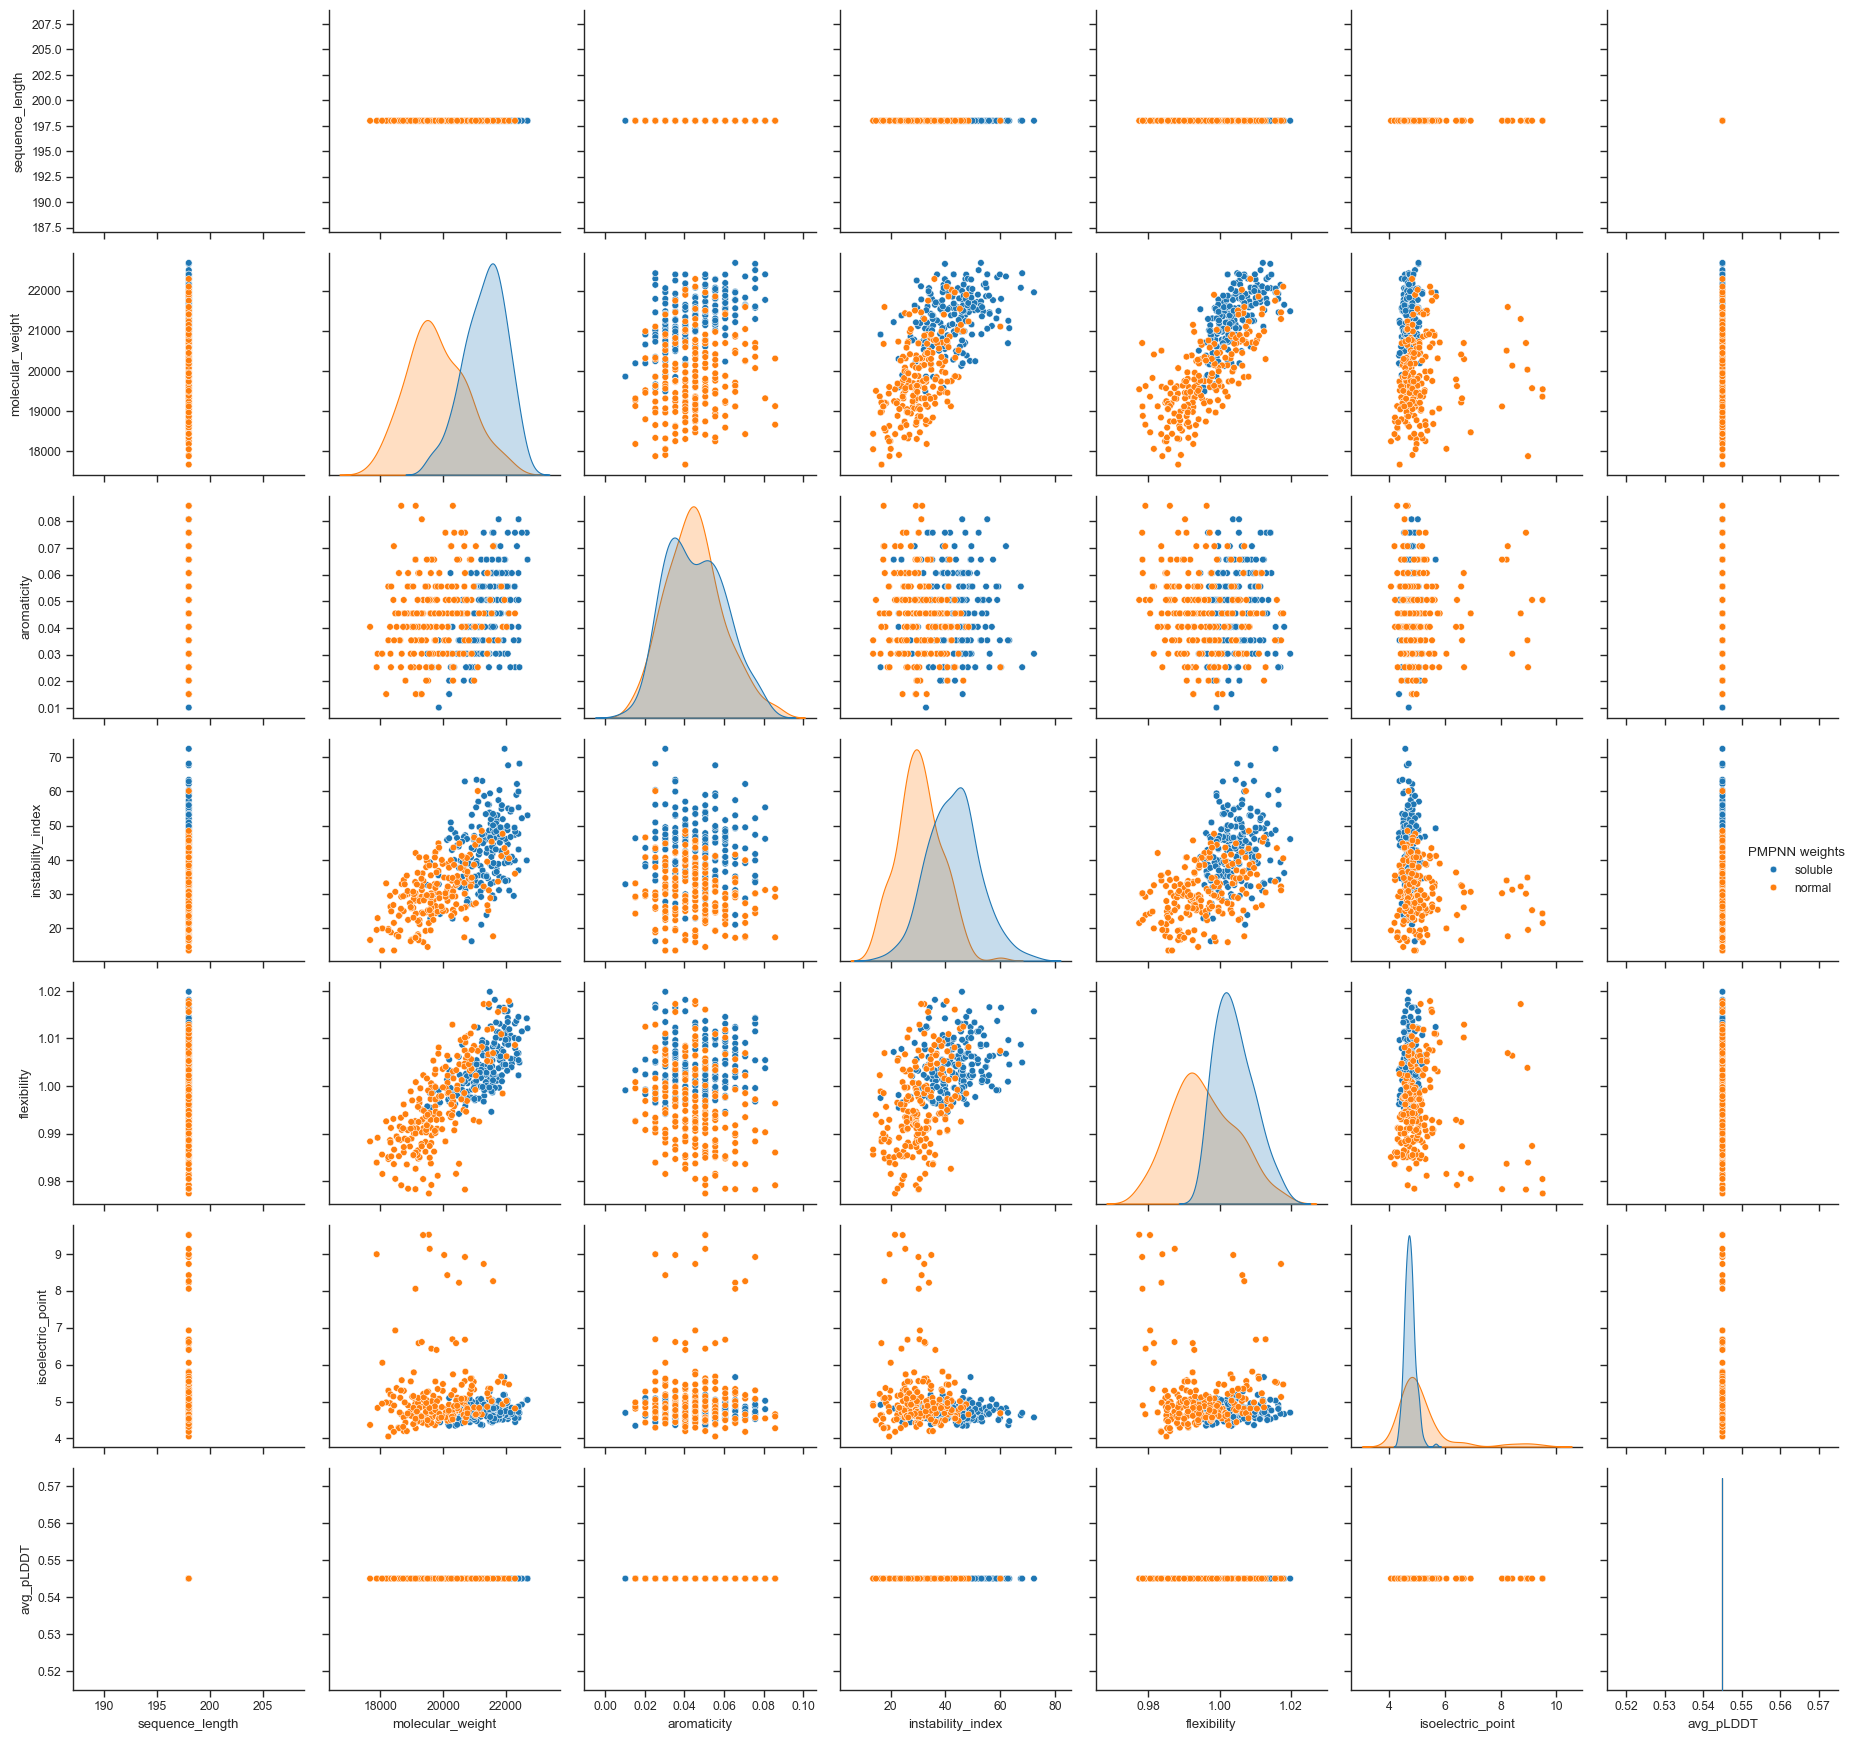

In [5]:
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(20,20),dpi=600) 
sns.pairplot(master_df, hue="PMPNN weights",)

plt.xticks(size=25)
plt.yticks(size=25)

plt.tight_layout()

plt.savefig('all_v_all_RFD_normal.png',transparent=True)
plt.show()

In [6]:
master_df = reduce_memory_usage(master_df)

Memory usage before reduction: 0.05 MB
Memory usage after reduction: 0.03 MB


In [7]:
normal_weights_final = master_df[master_df["PMPNN weights"]=='normal']
soluble_weights_final = master_df[master_df["PMPNN weights"]=='soluble']
master_df.to_csv(f'{rfdiff_dir}/master_df.csv')
del master_df

In [8]:
normal_weights_final = keep_top_score(normal_weights_final)
soluble_weights_final = keep_top_score(soluble_weights_final)
final_df = pd.concat([normal_weights_final,soluble_weights_final],axis=0).reset_index(drop=True)
RF_normal_df = final_df.copy()
del final_df

/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6495/1429492225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_2_per_pdb_file = sorted_df.groupby("pdb_file").head(2)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6495/1429492225.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df = top_2_per_pdb_file.groupby(["pdb_file", "PMPNN weights"]).head(1)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6495/1429492225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to r

In [9]:
# Define your base directories
base_dir = Path("./RF_diff/round2/")
rfdiff_dir = base_dir / "beta_weights"
weights_dir = rfdiff_dir / "PMPNN" / "normal_weights_chainA"

# Initialize a list to collect data
data = []

# Iterate over each .pdb file in the RFDiff_files directory
for pdb_file in rfdiff_dir.glob("*.pdb"):

    pdb_file_name = pdb_file.stem  # Get the .pdb file name without the extension
    
    # Construct the path to the corresponding .fa file
    fa_file_path = weights_dir / pdb_file_name / "seqs" / f"{pdb_file_name}.fa"
    
    # Check if the .fa file exists
    if fa_file_path.exists():
        # Open and read the .fa file
        with open(fa_file_path, "r") as fa_file:
            lines = fa_file.readlines()
        
        for line in lines:

            if line.startswith(">"):  # Header line with scores and metadata
                # Extract scores and metadata
                header_parts = line.strip().split(", ")
                metadata = {part.split("=")[0]: part.split("=")[1] for part in header_parts if "=" in part}
                
                # Prepare a new row for the DataFrame
                row = {
                    "pdb_file": pdb_file_name,
                    "sequence": "",  # Placeholder, will be filled with the next line
                    "score": metadata.get("score"),
                    "global_score": metadata.get("global_score"),
                    "seq_recovery": metadata.get("seq_recovery"),
                    "fasta_file_path": fa_file_path
                    # Add more metadata as needed
                }
                
            else:  # Sequence line
                row["sequence"] = line.strip()
                data.append(row)
    else:
        print(f'file was not found at {fa_file_path}')

# Convert the collected data into a pandas DataFrame
normal_pmpnn_weight_df = pd.DataFrame(data)
normal_pmpnn_weight_df['PMPNN weights']='normal'

In [10]:
weights_dir = rfdiff_dir / "PMPNN" / "soluble_weights_chainA"

# Initialize a list to collect data
data = []

# Iterate over each .pdb file in the RFDiff_files directory
for pdb_file in rfdiff_dir.glob("*.pdb"):
    pdb_file_name = pdb_file.stem  # Get the .pdb file name without the extension
    
    # Construct the path to the corresponding .fa file
    fa_file_path = weights_dir / pdb_file_name / "seqs" / f"{pdb_file_name}.fa"
    
    # Check if the .fa file exists
    if fa_file_path.exists():
        # Open and read the .fa file
        with open(fa_file_path, "r") as fa_file:
            lines = fa_file.readlines()
        
        for line in lines:
            if line.startswith(">"):  # Header line with scores and metadata
                # Extract scores and metadata
                header_parts = line.strip().split(", ")
                metadata = {part.split("=")[0]: part.split("=")[1] for part in header_parts if "=" in part}
                
                # Prepare a new row for the DataFrame
                row = {
                    "pdb_file": pdb_file_name,
                    "sequence": "",  # Placeholder, will be filled with the next line
                    "score": metadata.get("score"),
                    "global_score": metadata.get("global_score"),
                    "seq_recovery": metadata.get("seq_recovery"),
                    "fasta_file_path": fa_file_path
                    # Add more metadata as needed
                }
                
            else:  # Sequence line
                row["sequence"] = line.strip()
                data.append(row)
    else:
        print(f'file was not found at {fa_file_path}')

# Convert the collected data into a pandas DataFrame
soluble_pmpnn_weight_df = pd.DataFrame(data)

soluble_pmpnn_weight_df['PMPNN weights']='soluble'
master_df = pd.concat([soluble_pmpnn_weight_df,normal_pmpnn_weight_df],axis=0, ignore_index=True)
master_df['sequence_length'] = master_df['sequence'].str.len()
master_df['RDiff_pdb_file_path'] = master_df['pdb_file'].apply(lambda x: f"{rfdiff_dir}/{x}.pdb")
master_df = master_df.dropna(subset=['seq_recovery']).reset_index(drop=True)

# Apply the analysis function to each sequence in the DataFrame
analysis_results = master_df['sequence'].apply(lambda x: analyze_protein(x))

# Split the results into separate columns and assign them back to the DataFrame
master_df[['molecular_weight', 'aromaticity', 'instability_index', 'flexibility', 'isoelectric_point']] = pd.DataFrame(analysis_results.tolist(), index=master_df.index)

master_df = pdb_to_value_df(df=master_df,
                value_name='avg_pLDDT',
               function=pdb_pLDDT)
print(f"Number of RFDiff PDBs = {len(master_df['pdb_file'].value_counts())}, total number of sequences = {len(master_df)}")

RF_diff/round2/beta_weights/_16.pdb
RF_diff/round2/beta_weights/_1.pdb
RF_diff/round2/beta_weights/_0.pdb
RF_diff/round2/beta_weights/_17.pdb
RF_diff/round2/beta_weights/_29.pdb
RF_diff/round2/beta_weights/_15.pdb
RF_diff/round2/beta_weights/_2.pdb
RF_diff/round2/beta_weights/_3.pdb
RF_diff/round2/beta_weights/_14.pdb
RF_diff/round2/beta_weights/_28.pdb
RF_diff/round2/beta_weights/_10.pdb
RF_diff/round2/beta_weights/_38.pdb
RF_diff/round2/beta_weights/_7.pdb
RF_diff/round2/beta_weights/_6.pdb
RF_diff/round2/beta_weights/_39.pdb
RF_diff/round2/beta_weights/_11.pdb
RF_diff/round2/beta_weights/_13.pdb
RF_diff/round2/beta_weights/_4.pdb
RF_diff/round2/beta_weights/_5.pdb
RF_diff/round2/beta_weights/_12.pdb
RF_diff/round2/beta_weights/_49.pdb
RF_diff/round2/beta_weights/_48.pdb
RF_diff/round2/beta_weights/_40.pdb
RF_diff/round2/beta_weights/_41.pdb
RF_diff/round2/beta_weights/_43.pdb
RF_diff/round2/beta_weights/_42.pdb
RF_diff/round2/beta_weights/_46.pdb
RF_diff/round2/beta_weights/_47.pdb


<Figure size 640x480 with 0 Axes>

<Figure size 12000x12000 with 0 Axes>

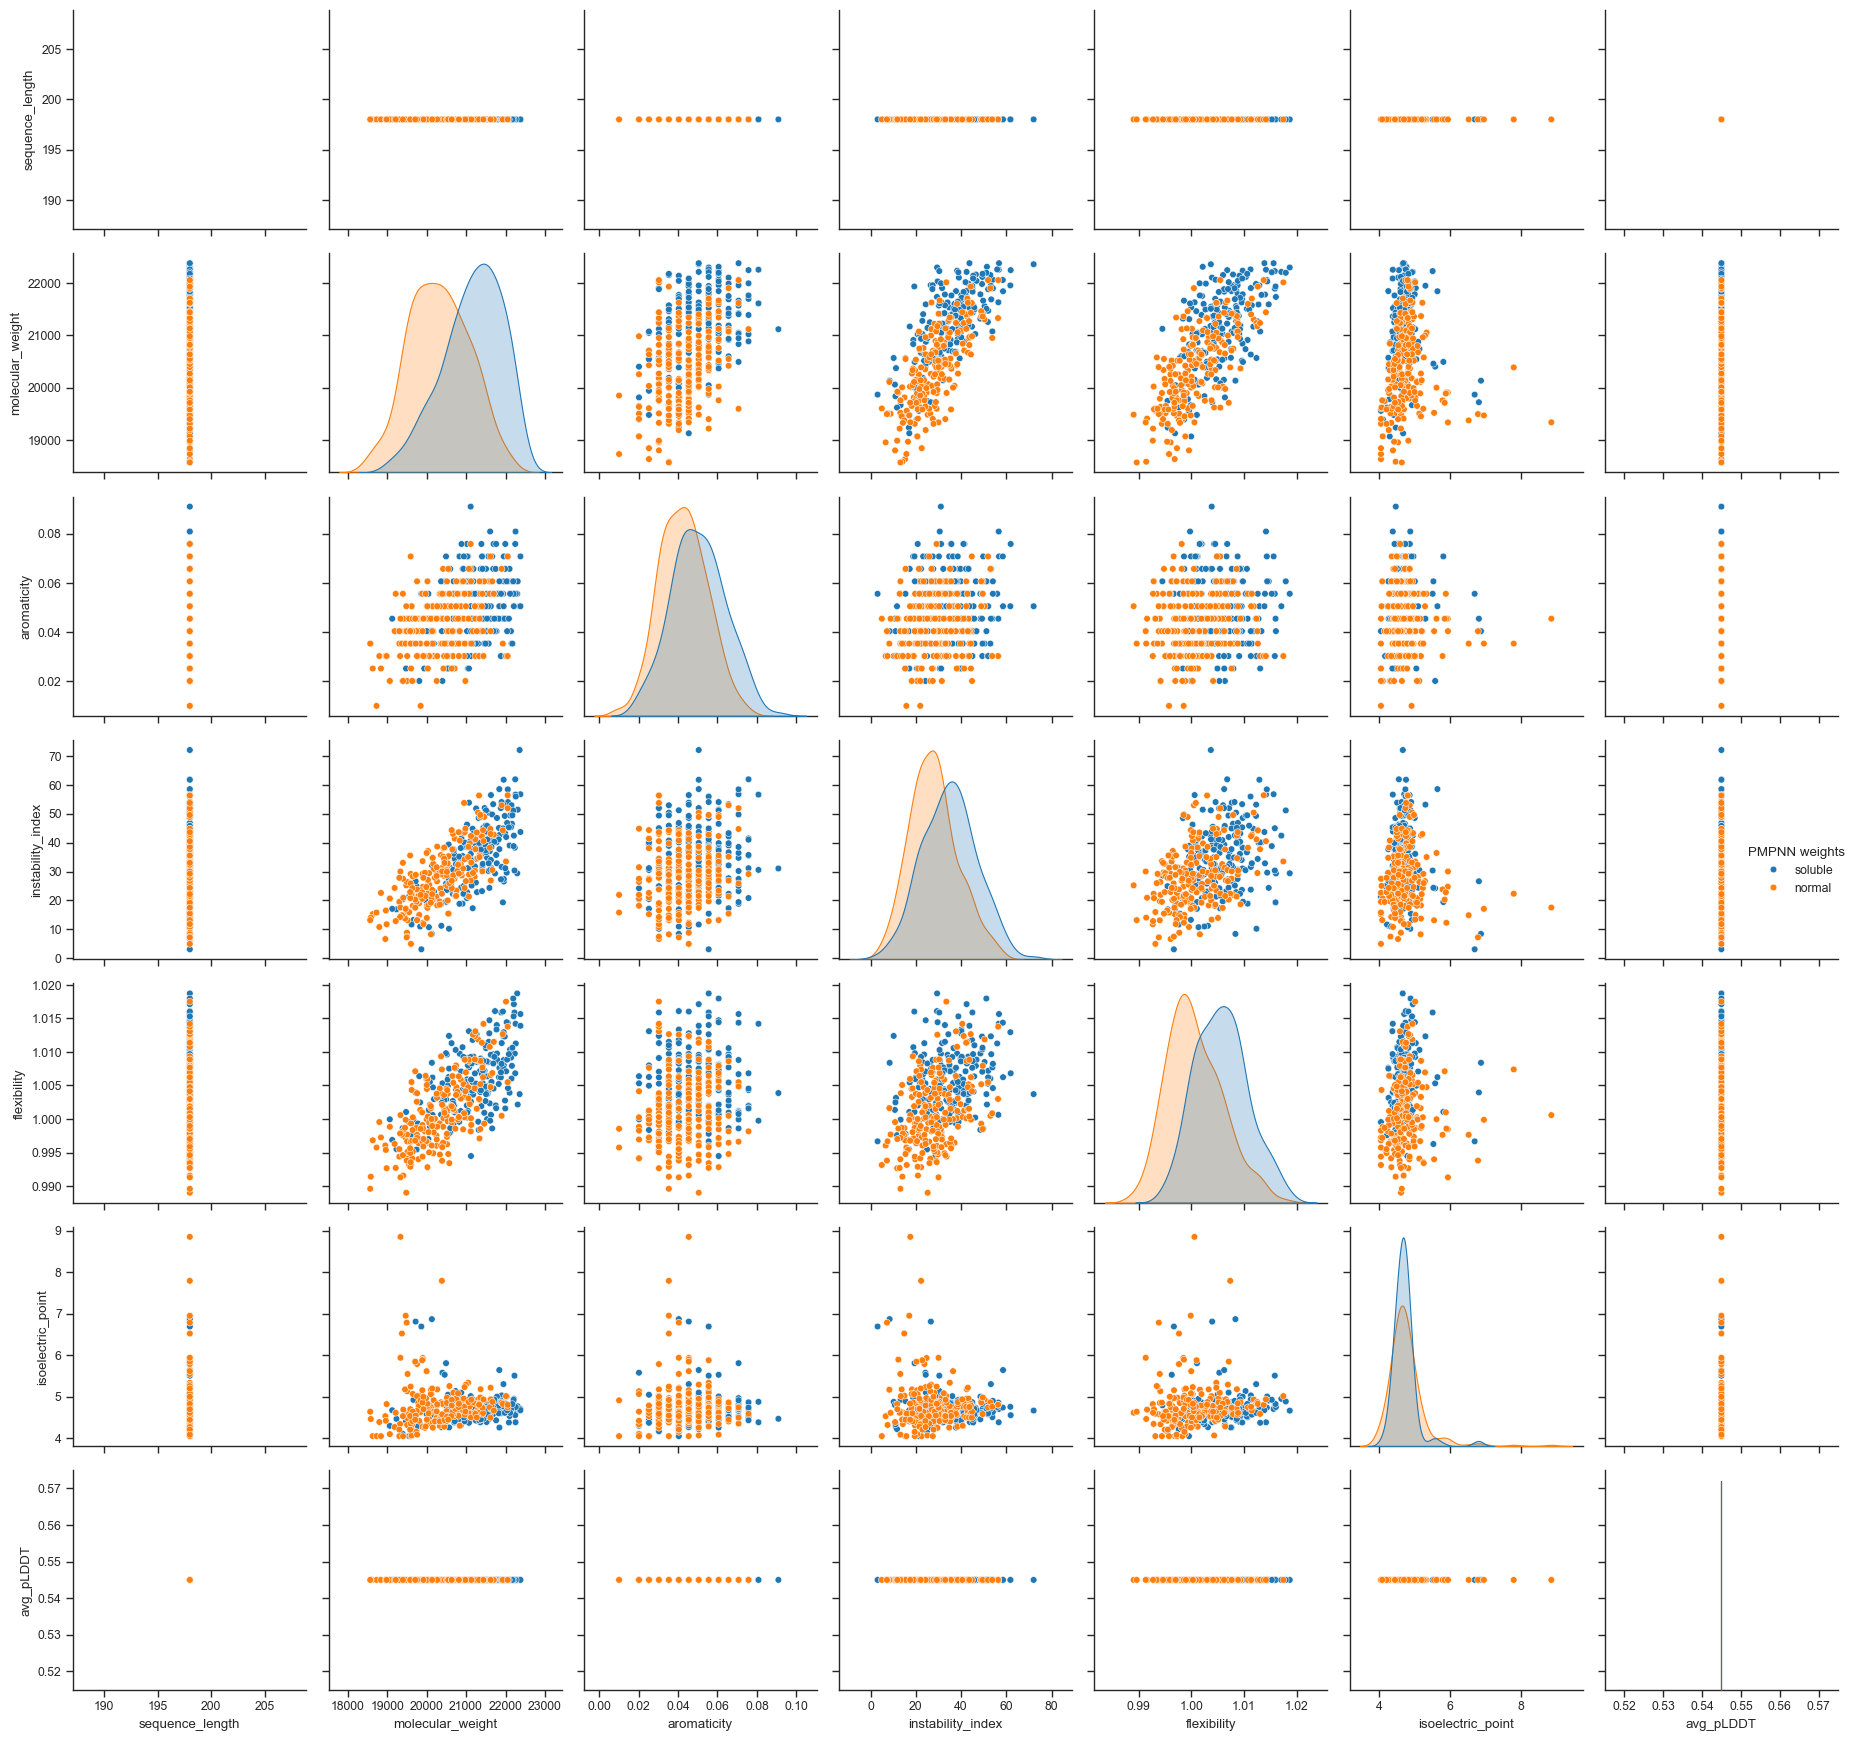

In [11]:
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(20,20),dpi=600) 
sns.pairplot(master_df, hue="PMPNN weights",)

plt.xticks(size=25)
plt.yticks(size=25)


plt.tight_layout()
plt.savefig('all_v_all_RFD_beta.png',transparent=True)
plt.show()


In [12]:
master_df = reduce_memory_usage(master_df)

Memory usage before reduction: 0.05 MB
Memory usage after reduction: 0.03 MB


In [13]:
normal_weights_final = master_df[master_df["PMPNN weights"]=='normal']
soluble_weights_final = master_df[master_df["PMPNN weights"]=='soluble']
master_df.to_csv(f'{rfdiff_dir}/master_df.csv')
del master_df

In [14]:
normal_weights_final = keep_top_score(normal_weights_final)
soluble_weights_final = keep_top_score(soluble_weights_final)
final_df = pd.concat([normal_weights_final,soluble_weights_final],axis=0).reset_index(drop=True)
RF_beta_df = final_df.copy()
del final_df

/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6495/1429492225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_2_per_pdb_file = sorted_df.groupby("pdb_file").head(2)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6495/1429492225.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df = top_2_per_pdb_file.groupby(["pdb_file", "PMPNN weights"]).head(1)
/var/folders/k0/7lzlp98x6c188pkk0rzbn2d40000gn/T/ipykernel_6495/1429492225.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to r

In [15]:
RF_beta_df['RF_weights']='Beta'
RF_normal_df['RF_weights']='Normal'

In [16]:
RF_beta_df

pdb_file                                           sequence   score  \
0        _0  LEKAIEALREGLRKGKELNSKNPYGSLIDPEEQKREVPPLTLVDPE...  0.9240   
1        _1  MREQAVADCAAAMAAAAALAKEPTIFNQPDDLAEKARKALEVLALL...  0.9125   
2       _10  AAPVAGANKQTMTVTVSITATTASGATVSASSTTSGATSATVTATA...  0.8507   
3       _11  AEAAAAAARARLEALAAALLAEPLPGSEEDLKAAIAAIAADIAAME...  0.9889   
4       _12  PQPGFSADVTRATAESGEDLGVPSNMEEYLAEAREMLDIGAELNIR...  1.0236   
..      ...                                                ...     ...   
95       _5  AEEAAERIIEEVRKQLDELYGEPYDEEATVGNIERALRAAMGLPAE...  0.9563   
96       _6  MEAKVDAEVAVTSVASPEVSNNDKGVGQKEEQDAQLKEYEEVLDKA...  0.9455   
97       _7  SELVQVKTTTTIRLSKEAPEKEPIGLHDEEKAKLAEGIREGAVSGK...  1.0252   
98       _8  EEELKKKIAEEIRKRAKELLKEDVEKRVKDIFEKMVELAAELVMEA...  0.9351   
99       _9  GPVVKVYEHVGTLRVRAELSSERLDSNATEEEKKIYAEAQAVAAEI...  0.9832   

   global_score seq_recovery  \
0        1.2002       0.0758   
1        1.1939       0.0707   
2        1.1665       0.1162   
3        1.2279       0.1010   
4        1.2700       0.0808   
..          ...          ...   
95       1.2210       0.0707   
96       1.2200       0.0909   
97       1.2490       0.1061   
98       1.1966       0.0657   
99       1.2345       0.1061   

                                      fasta_file_path PMPNN weights  \
0   RF_diff/round2/beta_weights/PMPNN/normal_weigh...        normal   
1   RF_diff/round2/beta_weights/PMPNN/normal_weigh...        normal   
2   RF_diff/round2/beta_weights/PMPNN/normal_weigh...        normal   
3   RF_diff/round2/beta_weights/PMPNN/normal_weigh...        normal   
4   RF_diff/round2/beta_weights/PMPNN/normal_weigh...        normal   
..                                                ...           ...   
95  RF_diff/round2/beta_weights/PMPNN/soluble_weig...       soluble   
96  RF_diff/round2/beta_weights/PMPNN/soluble_weig...       soluble   
97  RF_diff/round2/beta_weights/PMPNN/soluble_weig...       soluble   
98  RF_diff/round2/beta_weights/PMPNN/soluble_weig...       soluble   
99  RF_diff/round2/beta_weights/PMPNN/soluble_weig...       soluble   

    sequence_length                  RDiff_pdb_file_path  molecular_weight  \
0               198   RF_diff/round2/beta_weights/_0.pdb           21296.0   
1               198   RF_diff/round2/beta_weights/_1.pdb           20336.0   
2               198  RF_diff/round2/beta_weights/_10.pdb           18640.0   
3               198  RF_diff/round2/beta_weights/_11.pdb           18976.0   
4               198  RF_diff/round2/beta_weights/_12.pdb           20816.0   
..              ...                                  ...               ...   
95              198   RF_diff/round2/beta_weights/_5.pdb           21312.0   
96              198   RF_diff/round2/beta_weights/_6.pdb           21024.0   
97              198   RF_diff/round2/beta_weights/_7.pdb           20144.0   
98              198   RF_diff/round2/beta_weights/_8.pdb           21488.0   
99              198   RF_diff/round2/beta_weights/_9.pdb           20560.0   

    aromaticity  instability_index  flexibility  isoelectric_point  avg_pLDDT  \
0      0.040405          34.625000     1.008789           4.667969   0.544922   
1      0.055542          19.671875     0.999512           4.300781   0.544922   
2      0.025253          15.265625     0.997070           4.050781   0.544922   
3      0.030304          16.531250     0.995605           4.421875   0.544922   
4      0.055542          32.593750     1.003906           4.539062   0.544922   
..          ...                ...          ...                ...        ...   
95     0.055542          48.500000     0.998535           4.457031   0.544922   
96     0.060608          21.656250     1.005859           4.566406   0.544922   
97     0.040405          19.937500     1.005859           4.566406   0.544922   
98     0.050507          39.125000     1.004883           4.875000   0.544922   
99     0.055542          15.429688     0.997559 

In [17]:
final_df = pd.concat([RF_normal_df,RF_beta_df],axis=0).reset_index(drop=True)


In [18]:
def write_fasta_files(df, folder_path):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Iterate over rows of the dataframe
    for index, row in df.iterrows():
        # Generate the filename for the FASTA file using the pdb_file column
        file_name = f"{row['PMPNN weights']}{row['pdb_file']}.fasta"
        file_path = os.path.join(folder_path, file_name)
        
        # Write the sequence to the FASTA file
        with open(file_path, "w") as fasta_file:
            fasta_file.write(f">{index}\n")
            fasta_file.write(f"{row['sequence']}\n")
        
        # Update the dataframe with the file path
        df.at[index, 'fasta_path'] = file_path
    
    return df


folder_path = "./att2/RF_beta/all_fastas"
RF_beta_df = write_fasta_files(RF_beta_df, folder_path)
folder_path = "./att2/RF_normal/all_fastas"
RF_normal_df = write_fasta_files(RF_normal_df, folder_path)

<Figure size 640x480 with 0 Axes>

<Figure size 19200x19200 with 0 Axes>

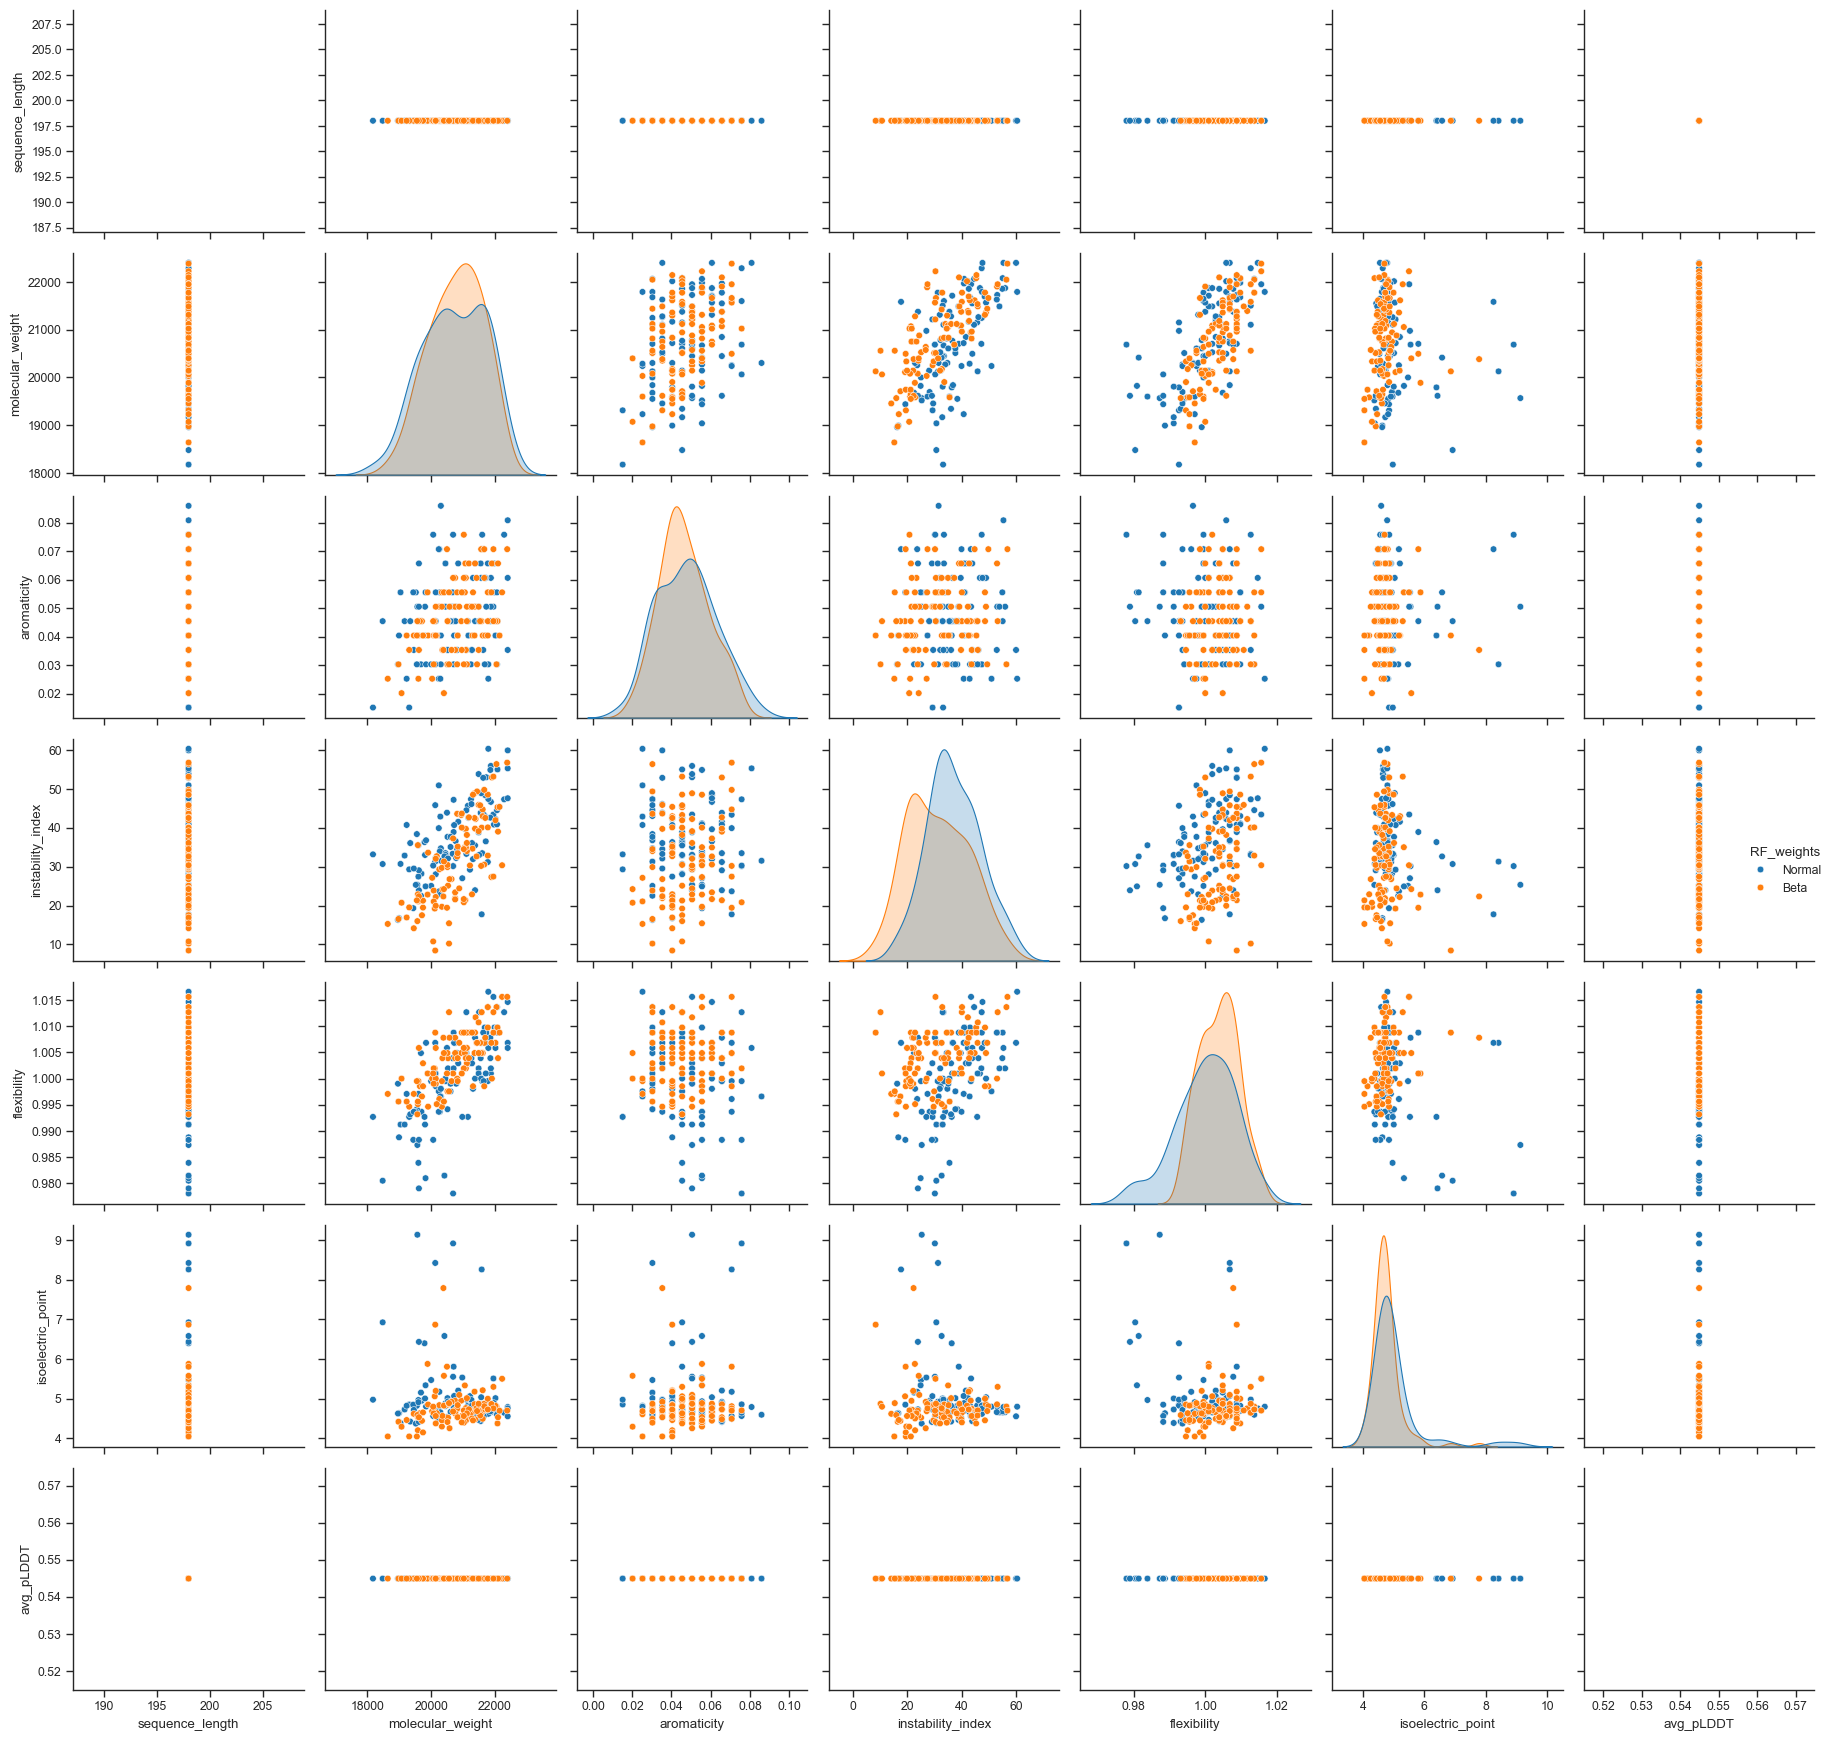

In [19]:
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(32,32),dpi=600) 
sns.pairplot(final_df, hue="RF_weights",)

plt.xticks(size=25)
plt.yticks(size=25)

plt.tight_layout()
plt.savefig('all_v_all_RFD_weights.png',transparent=True)
plt.show()

In [20]:
!pwd

/Users/phr361/Documents/Coding/ProteinDesign/AntiAntiDefence/ProteinDesignCompAug


/Users/phr361/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [21]:
mapping_dict = {
    'normal': 'normal',
    'soluble': 'soluble'
}
path_to_ESM = './att2/RF_beta/ESM_outputs/'

# Function to map pdb_file to result file path
def map_result_path(row):
    
    def find_pdb_file(pdb_dir):
        try:
            pdb_files = [f for f in os.listdir(pdb_dir) if f.endswith('.pdb')]
            if pdb_files:
                return os.path.join(pdb_dir, pdb_files[0])
            else:
                return None
        except FileNotFoundError:
            return None
    
    weight_type = mapping_dict.get(row['PMPNN weights'])
    pdb_number = row['pdb_file']
    result_file = f"{weight_type}{pdb_number}_result/"
    result_path = os.path.join(path_to_ESM, result_file)
    result = find_pdb_file(result_path)
    print(result)
    return result

RF_beta_df['ESM_pdb_path'] = RF_beta_df.apply(map_result_path, axis=1)




None
./att2/RF_beta/ESM_outputs/normal_1_result/1.pdb
./att2/RF_beta/ESM_outputs/normal_10_result/2.pdb
./att2/RF_beta/ESM_outputs/normal_11_result/3.pdb
./att2/RF_beta/ESM_outputs/normal_12_result/4.pdb
./att2/RF_beta/ESM_outputs/normal_13_result/5.pdb
./att2/RF_beta/ESM_outputs/normal_14_result/6.pdb
./att2/RF_beta/ESM_outputs/normal_15_result/7.pdb
./att2/RF_beta/ESM_outputs/normal_16_result/8.pdb
./att2/RF_beta/ESM_outputs/normal_17_result/9.pdb
./att2/RF_beta/ESM_outputs/normal_18_result/10.pdb
./att2/RF_beta/ESM_outputs/normal_19_result/11.pdb
./att2/RF_beta/ESM_outputs/normal_2_result/12.pdb
./att2/RF_beta/ESM_outputs/normal_20_result/13.pdb
./att2/RF_beta/ESM_outputs/normal_21_result/14.pdb
./att2/RF_beta/ESM_outputs/normal_22_result/15.pdb
./att2/RF_beta/ESM_outputs/normal_23_result/16.pdb
./att2/RF_beta/ESM_outputs/normal_24_result/17.pdb
./att2/RF_beta/ESM_outputs/normal_25_result/18.pdb
./att2/RF_beta/ESM_outputs/normal_26_result/19.pdb
./att2/RF_beta/ESM_outputs/normal_27_

In [22]:
# Apply the function to create the new column
path_to_ESM = './att2/RF_normal/ESM_outputs/'

RF_normal_df['ESM_pdb_path'] = RF_normal_df.apply(map_result_path, axis=1)

None
./att2/RF_normal/ESM_outputs/normal_1_result/1.pdb
./att2/RF_normal/ESM_outputs/normal_10_result/2.pdb
./att2/RF_normal/ESM_outputs/normal_11_result/3.pdb
./att2/RF_normal/ESM_outputs/normal_12_result/4.pdb
./att2/RF_normal/ESM_outputs/normal_13_result/5.pdb
./att2/RF_normal/ESM_outputs/normal_14_result/6.pdb
./att2/RF_normal/ESM_outputs/normal_15_result/7.pdb
./att2/RF_normal/ESM_outputs/normal_16_result/8.pdb
./att2/RF_normal/ESM_outputs/normal_17_result/9.pdb
./att2/RF_normal/ESM_outputs/normal_18_result/10.pdb
./att2/RF_normal/ESM_outputs/normal_19_result/11.pdb
./att2/RF_normal/ESM_outputs/normal_2_result/12.pdb
./att2/RF_normal/ESM_outputs/normal_20_result/13.pdb
./att2/RF_normal/ESM_outputs/normal_21_result/14.pdb
./att2/RF_normal/ESM_outputs/normal_22_result/15.pdb
./att2/RF_normal/ESM_outputs/normal_23_result/16.pdb
./att2/RF_normal/ESM_outputs/normal_24_result/17.pdb
./att2/RF_normal/ESM_outputs/normal_25_result/18.pdb
./att2/RF_normal/ESM_outputs/normal_26_result/19.pdb

In [23]:

from Bio.PDB import PDBParser, PDBIO, Select


def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def extract_chain_and_save(df, pdb_column,  new_pdb_folder, new_column_name,chain_id=0):
    
    ensure_directory(new_pdb_folder)
    
    for index, row in df.iterrows():
        pdb_path = row[pdb_column]
        
        base_pdb_path, _ = os.path.splitext(os.path.basename(pdb_path))

        new_pdb_path = os.path.join(new_pdb_folder, f"{base_pdb_path}_{chain_id}.pdb")
        
        try:
            assembly = ampal.load_pdb(pdb_path)
            chain = assembly[chain_id]
            A=open(new_pdb_path,'w')
            print(chain.pdb,file=A)
            A.close()

            df.at[index, new_column_name] = new_pdb_path
        except Exception as e:
            print(f"Error processing file {pdb_path}: {e}")

    return df


In [24]:
df = RF_beta_df.copy()
pdb_column = 'RDiff_pdb_file_path'
chain_id = 'A'
new_pdb_folder = './att2/RF_beta/RFDiff_files/binders_only'

new_column_name = 'RFDiff_binder_pdb_path'

RF_beta_df = extract_chain_and_save(df, pdb_column, 
                                                new_pdb_folder, 
                                                new_column_name)


In [25]:
df = RF_normal_df.copy()
pdb_column = 'RDiff_pdb_file_path'
chain_id = 'A'
new_pdb_folder = './att2/RF_normal/RFDiff_files/binders_only'

new_column_name = 'RFDiff_binder_pdb_path'

RF_normal_df = extract_chain_and_save(df, pdb_column,  
                                                new_pdb_folder, 
                                                new_column_name)


In [26]:
RF_normal_df['ESM_pdb_path'].replace({None: np.nan}, inplace=True)
RF_beta_df['ESM_pdb_path'].replace({None: np.nan}, inplace=True)

In [27]:
final_df = pd.concat([RF_beta_df,RF_normal_df],axis=0).reset_index(drop=True)


In [28]:
final_df=final_df.dropna()
final_df=final_df.reset_index()

In [29]:
final_df = pdb_to_value_df(df=final_df,
                value_name='ESMFold_pLDDT',
               function=pdb_pLDDT,pdb_path_column='ESM_pdb_path')

./att2/RF_beta/ESM_outputs/normal_1_result/1.pdb
./att2/RF_beta/ESM_outputs/normal_10_result/2.pdb
./att2/RF_beta/ESM_outputs/normal_11_result/3.pdb
./att2/RF_beta/ESM_outputs/normal_12_result/4.pdb
./att2/RF_beta/ESM_outputs/normal_13_result/5.pdb
./att2/RF_beta/ESM_outputs/normal_14_result/6.pdb
./att2/RF_beta/ESM_outputs/normal_15_result/7.pdb
./att2/RF_beta/ESM_outputs/normal_16_result/8.pdb
./att2/RF_beta/ESM_outputs/normal_17_result/9.pdb
./att2/RF_beta/ESM_outputs/normal_18_result/10.pdb
./att2/RF_beta/ESM_outputs/normal_19_result/11.pdb
./att2/RF_beta/ESM_outputs/normal_2_result/12.pdb
./att2/RF_beta/ESM_outputs/normal_20_result/13.pdb
./att2/RF_beta/ESM_outputs/normal_21_result/14.pdb
./att2/RF_beta/ESM_outputs/normal_22_result/15.pdb
./att2/RF_beta/ESM_outputs/normal_23_result/16.pdb
./att2/RF_beta/ESM_outputs/normal_24_result/17.pdb
./att2/RF_beta/ESM_outputs/normal_25_result/18.pdb
./att2/RF_beta/ESM_outputs/normal_26_result/19.pdb
./att2/RF_beta/ESM_outputs/normal_27_resul

In [30]:
import nglview
pdb_of_interest = final_df['RDiff_pdb_file_path'][0]
view = nglview.show_structure_file(pdb_of_interest) 
view

NGLWidget()

In [31]:
pdb_of_interest = final_df['RFDiff_binder_pdb_path'][0]
view = nglview.show_structure_file(pdb_of_interest) 
view

NGLWidget()

In [32]:
pdb_of_interest = final_df['ESM_pdb_path'][0]
view = nglview.show_structure_file(pdb_of_interest) 
view

NGLWidget()

In [33]:
def add_TM_score_to_df(row):
    pdb_path = row['ESM_pdb_path']
    rdiff_pdb_path = row['RFDiff_binder_pdb_path']
    tm_score = protein_design_utils.TM_score(pdb_path, rdiff_pdb_path)
    return tm_score

# Applying the function to each row of the DataFrame
final_df['RFDiff_ESM_TM_score'] = final_df.apply(add_TM_score_to_df, axis=1)



No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the output: out.txt
No TM found, please check the outp

################
###Saving data and plot###
################


<Figure size 640x480 with 0 Axes>

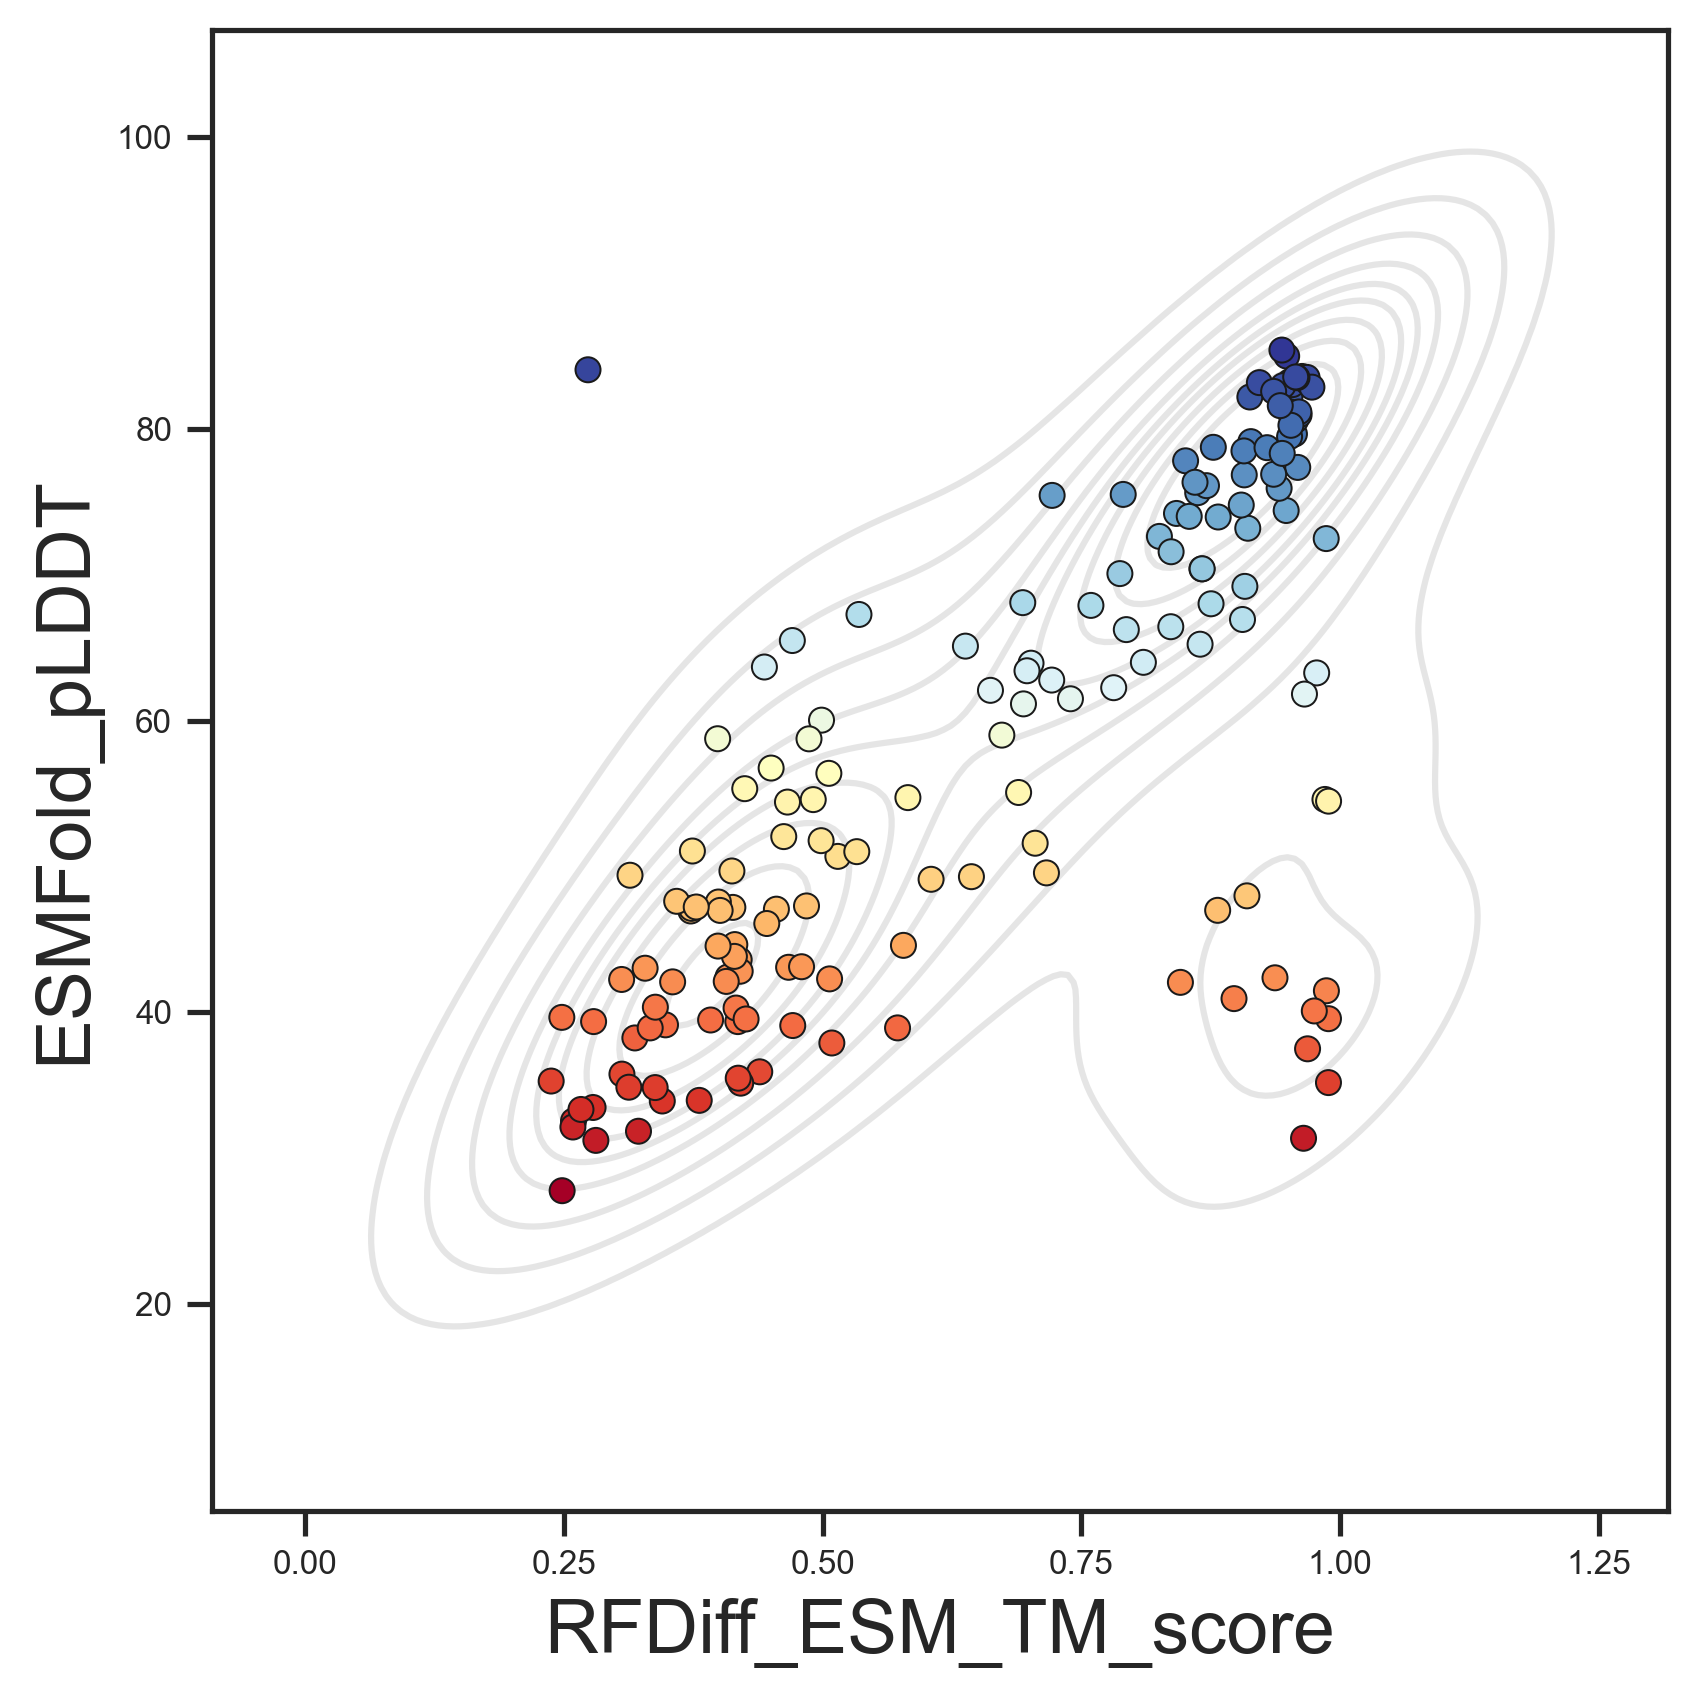

In [34]:
fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu='ESMFold_pLDDT'
df=final_df.copy()
sns.scatterplot(data=df,x='RFDiff_ESM_TM_score',y='ESMFold_pLDDT',hue=hu,sizes='RFDiff_ESM_TM_score',palette='RdYlBu',edgecolor='k')
sns.kdeplot(data=df,x='RFDiff_ESM_TM_score',y='ESMFold_pLDDT',color='grey',levels=10,alpha=0.2,zorder=-1)

#plt.legend(title=hu,loc=(1.1,0.1))
plt.legend('',frameon=False)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
#plt.ylabel('2BC/(BB+CC) (REU)',fontsize=12)
#plt.xlabel('Generation',fontsize=12)
plt.tight_layout()
print('################\n###Saving data and plot###\n################')
#plt.savefig('output.svg',transparent=True,dpi=2000)


################
###Saving data and plot###
################


<Figure size 640x480 with 0 Axes>

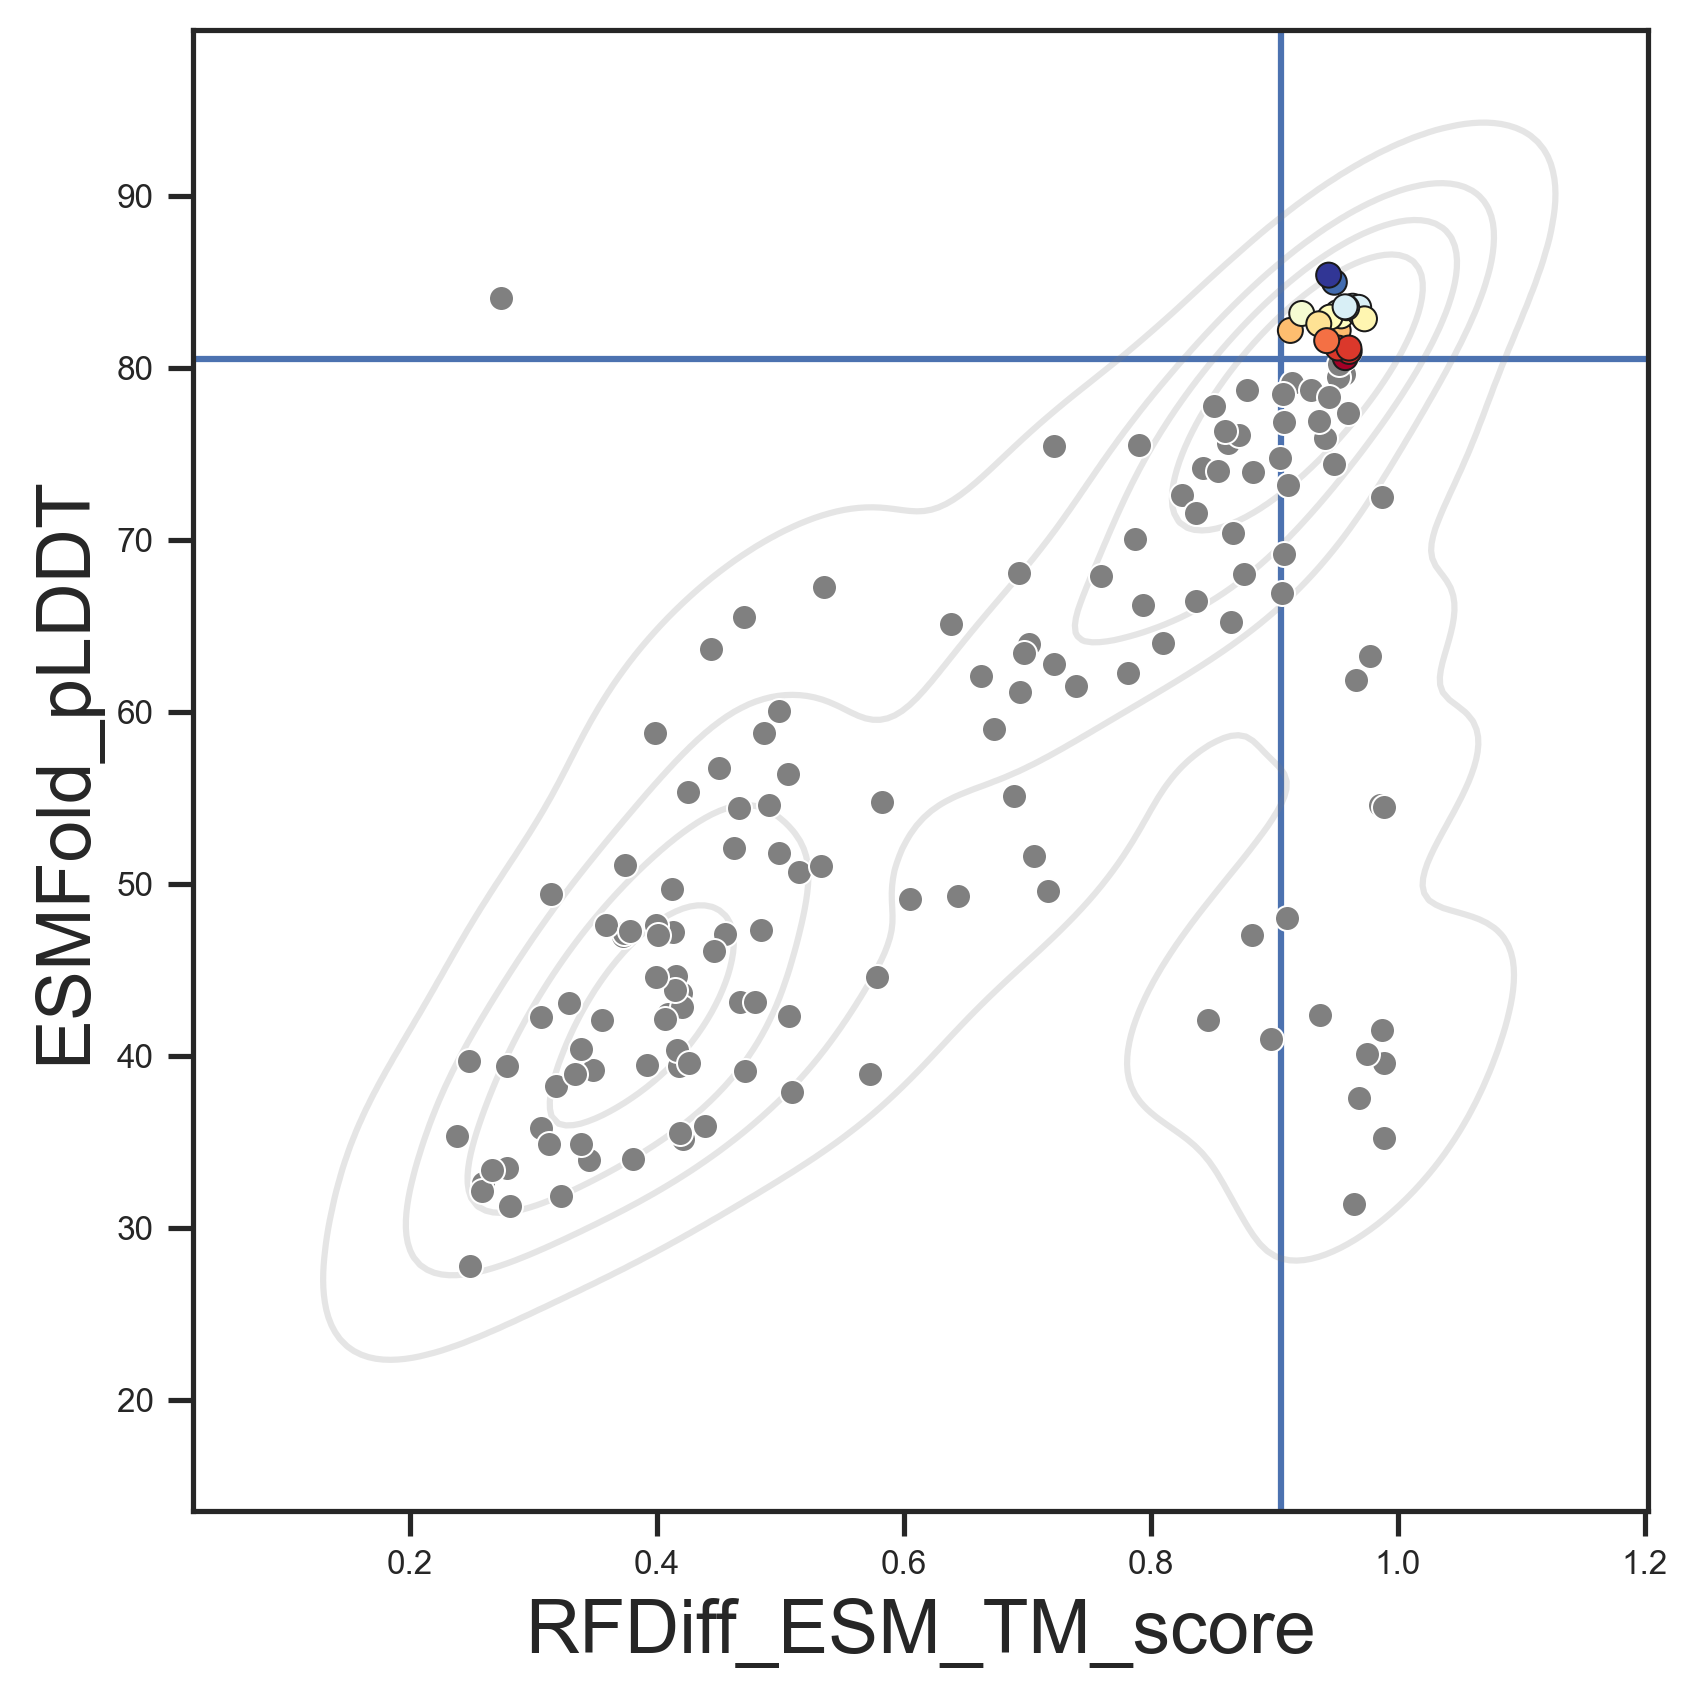

In [37]:
df=final_df.copy()

cut_TM = 0.905 #0.26
cut_pLDDT = 0.805*100

TM_col_name = 'RFDiff_ESM_TM_score'
pLDDT_col_name = 'ESMFold_pLDDT'
df_TM = df[df[TM_col_name]>cut_TM]
df_pLDDT = df_TM[df_TM[pLDDT_col_name]>cut_pLDDT]
df_best = df_pLDDT[df_pLDDT[TM_col_name]>cut_TM]

fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu=pLDDT_col_name

plt.axhline(y=cut_pLDDT,zorder=-2)
plt.axvline(x=cut_TM,zorder=-2)

sns.scatterplot(data=df,x=TM_col_name,y=pLDDT_col_name,color='grey',zorder=0)
sns.scatterplot(data=df_best,x=TM_col_name,y=pLDDT_col_name,hue=hu,palette='RdYlBu',edgecolor='k',zorder=1)

sns.kdeplot(data=df,x=TM_col_name,y=pLDDT_col_name,color='grey',bw_adjust=0.65,levels=5,alpha=0.2,zorder=-1)
#sns.scatterplot(data=df,x='TM-scores',y='pLDDT',sizes='Length')
#sns.lmplot(data=df,x='TM-scores',y='pLDDT',ci='sd')
plt.legend('',frameon=False)
#plt.legend(title=hu,loc=(1.1,0.1))

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
#plt.ylabel('2BC/(BB+CC) (REU)',fontsize=12)
#plt.xlabel('Generation',fontsize=12)
plt.tight_layout()
print('################\n###Saving data and plot###\n################')
#plt.savefig('output.svg',transparent=True,dpi=2000)


In [38]:
len(df_best)

20

<Figure size 640x480 with 0 Axes>

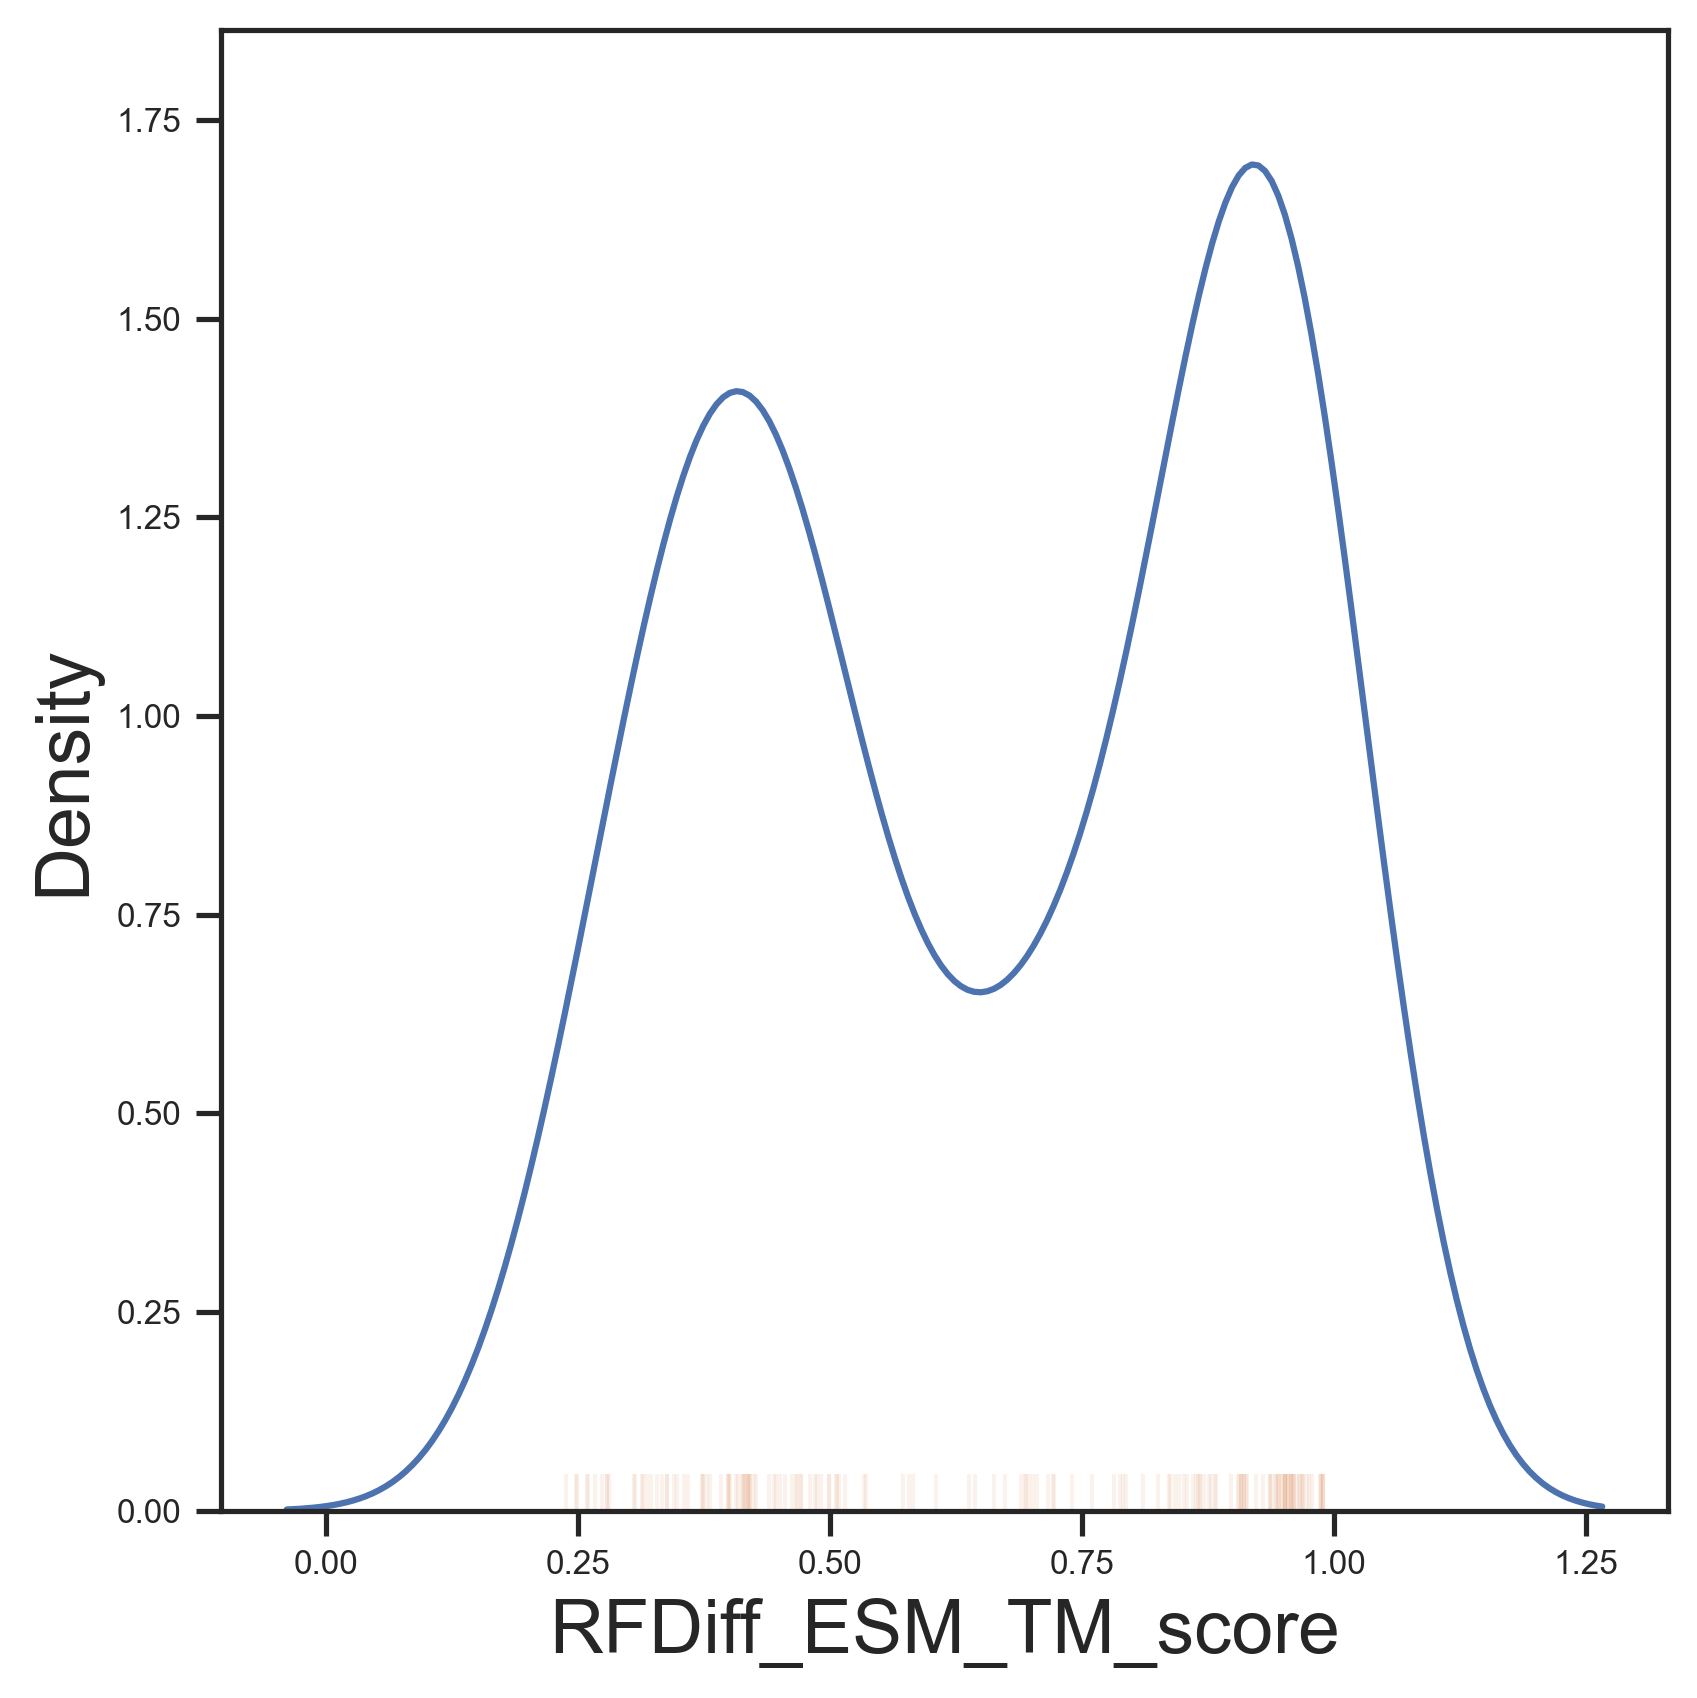

In [39]:
fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu='ESMFold_pLDDT'
df=final_df.copy()

sns.kdeplot(data=df,x='RFDiff_ESM_TM_score')
sns.rugplot(data=df,x='RFDiff_ESM_TM_score',alpha=0.1)

#plt.legend(title=hu,loc=(1.1,0.1))
plt.legend('',frameon=False)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.tight_layout()
#plt.savefig('output.svg',transparent=True,dpi=2000)


<Figure size 640x480 with 0 Axes>

<Figure size 19200x19200 with 0 Axes>

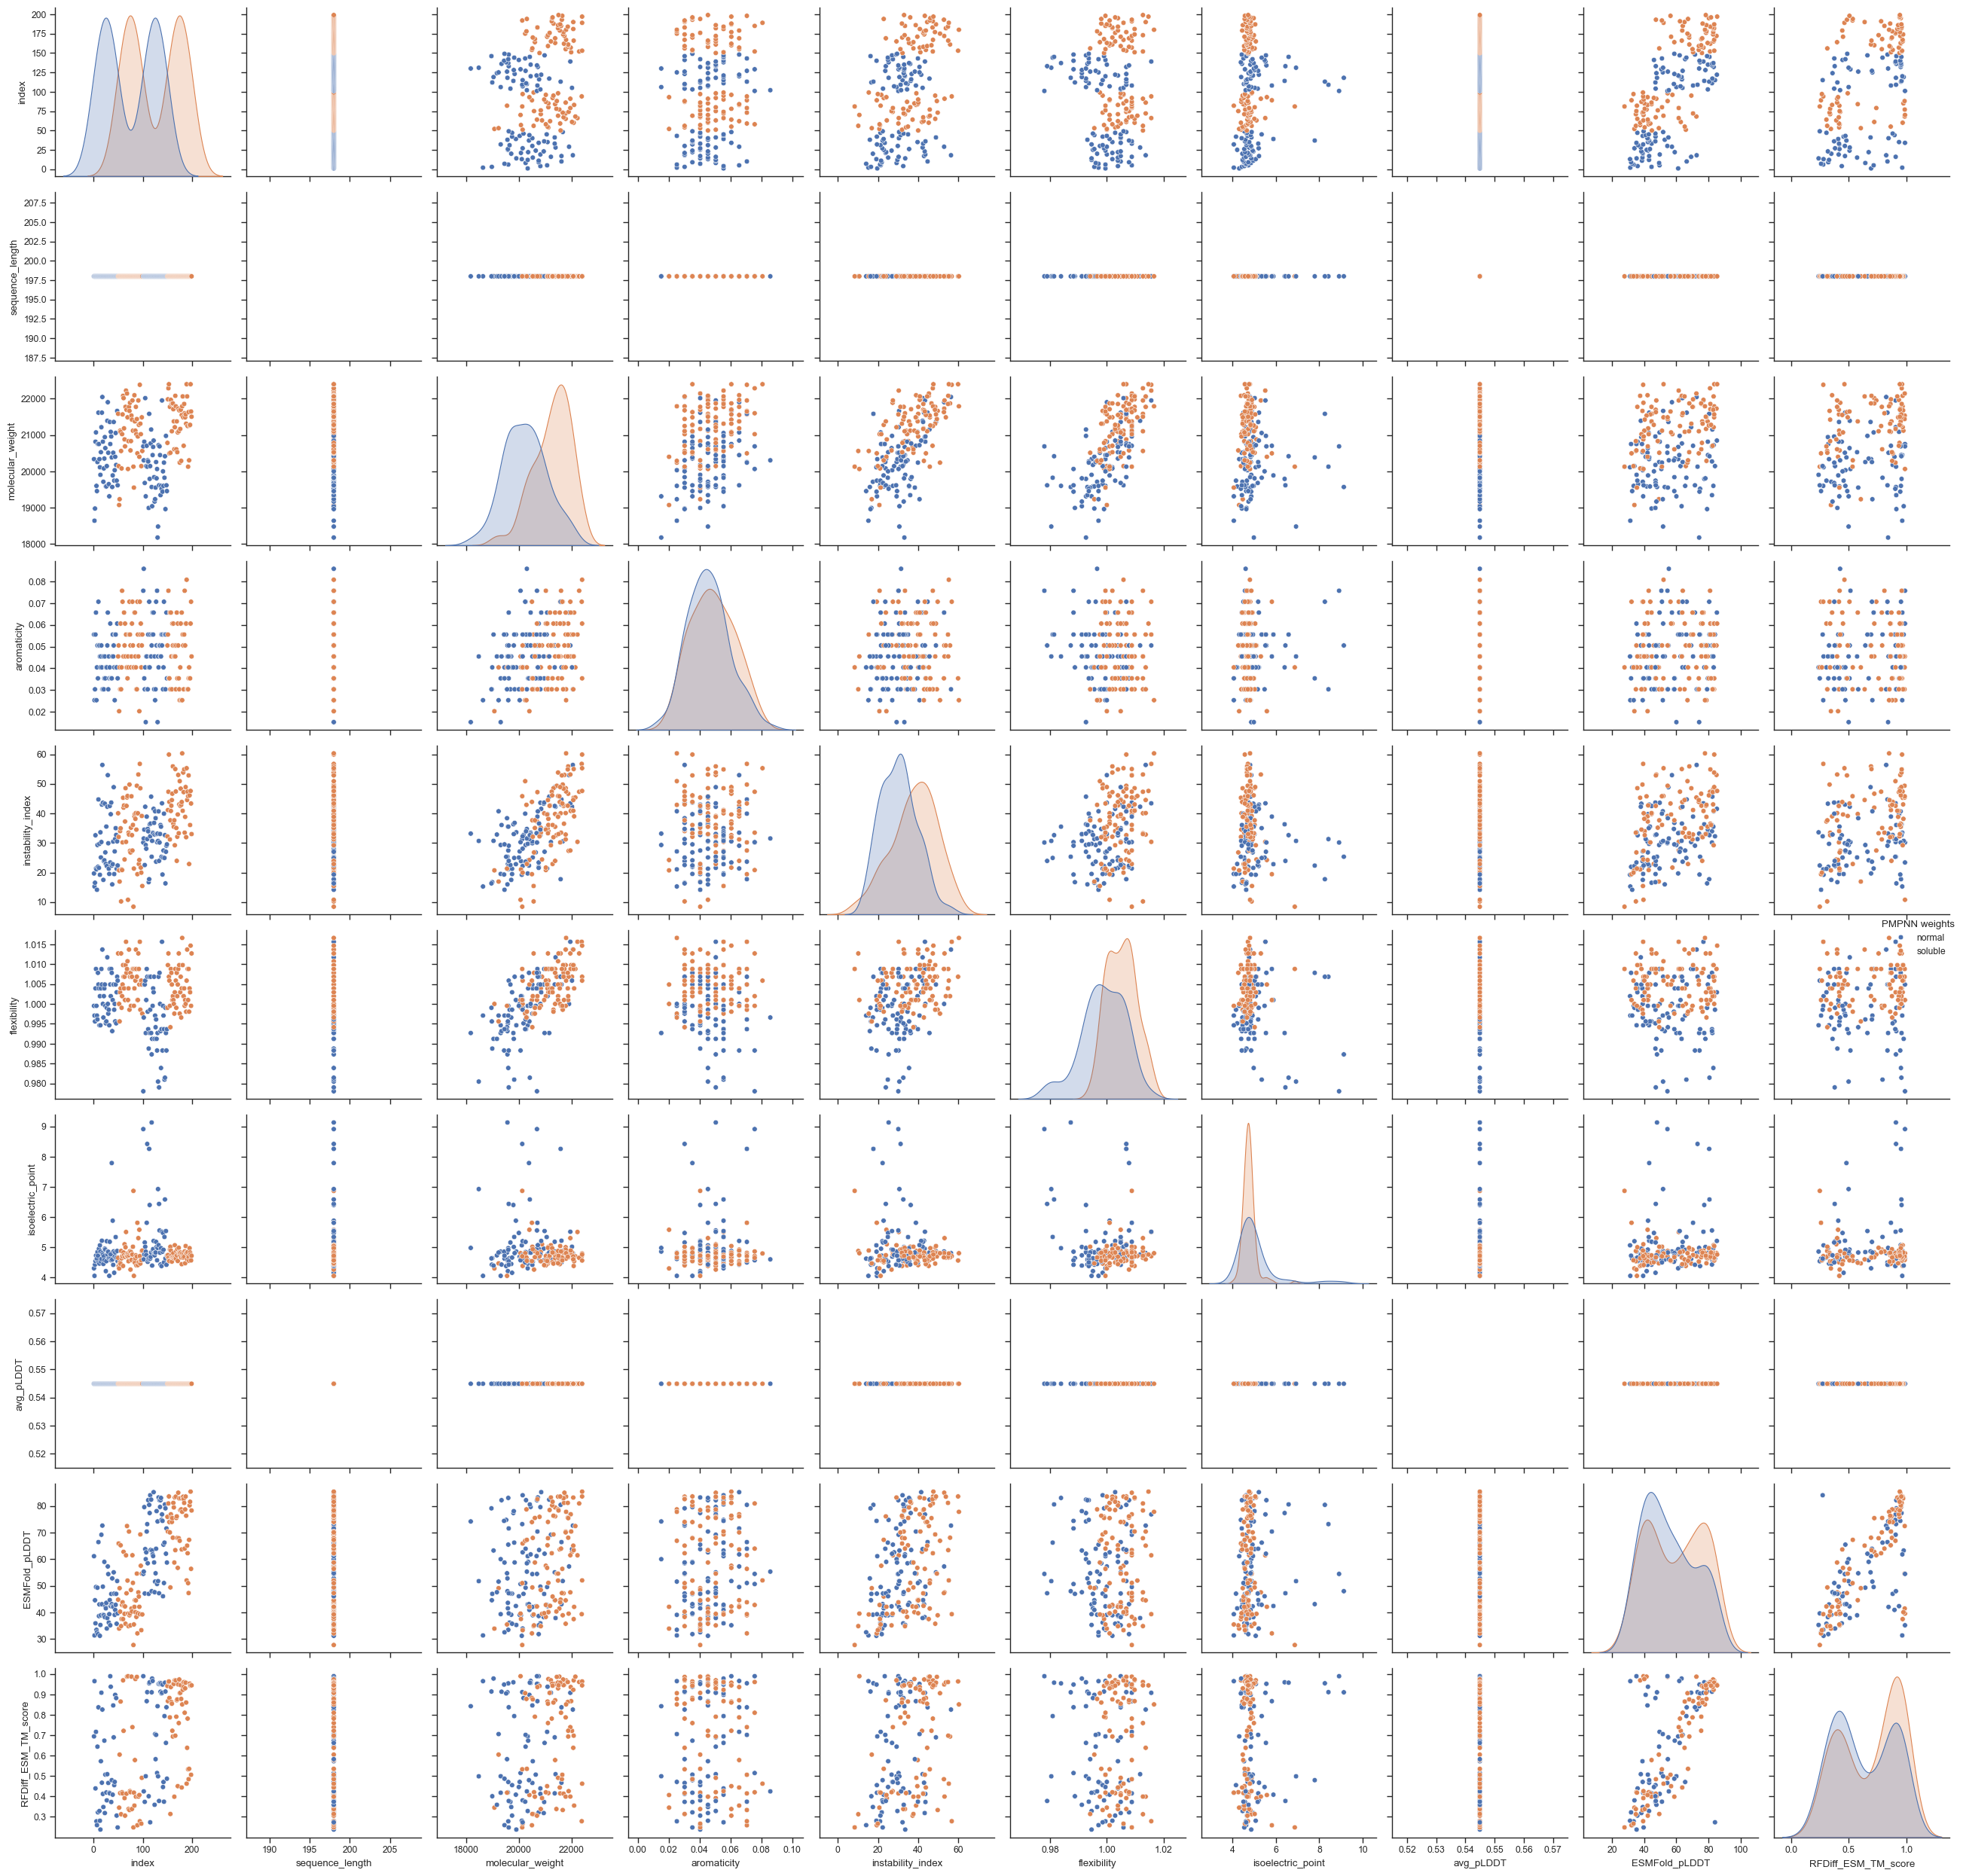

In [40]:
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(32,32),dpi=600) 
sns.pairplot(final_df, hue="PMPNN weights",)

plt.xticks(size=25)
plt.yticks(size=25)

plt.tight_layout()
plt.savefig('all_v_all_final_PMPNN_weights.png',transparent=True)
plt.show()

<Figure size 640x480 with 0 Axes>

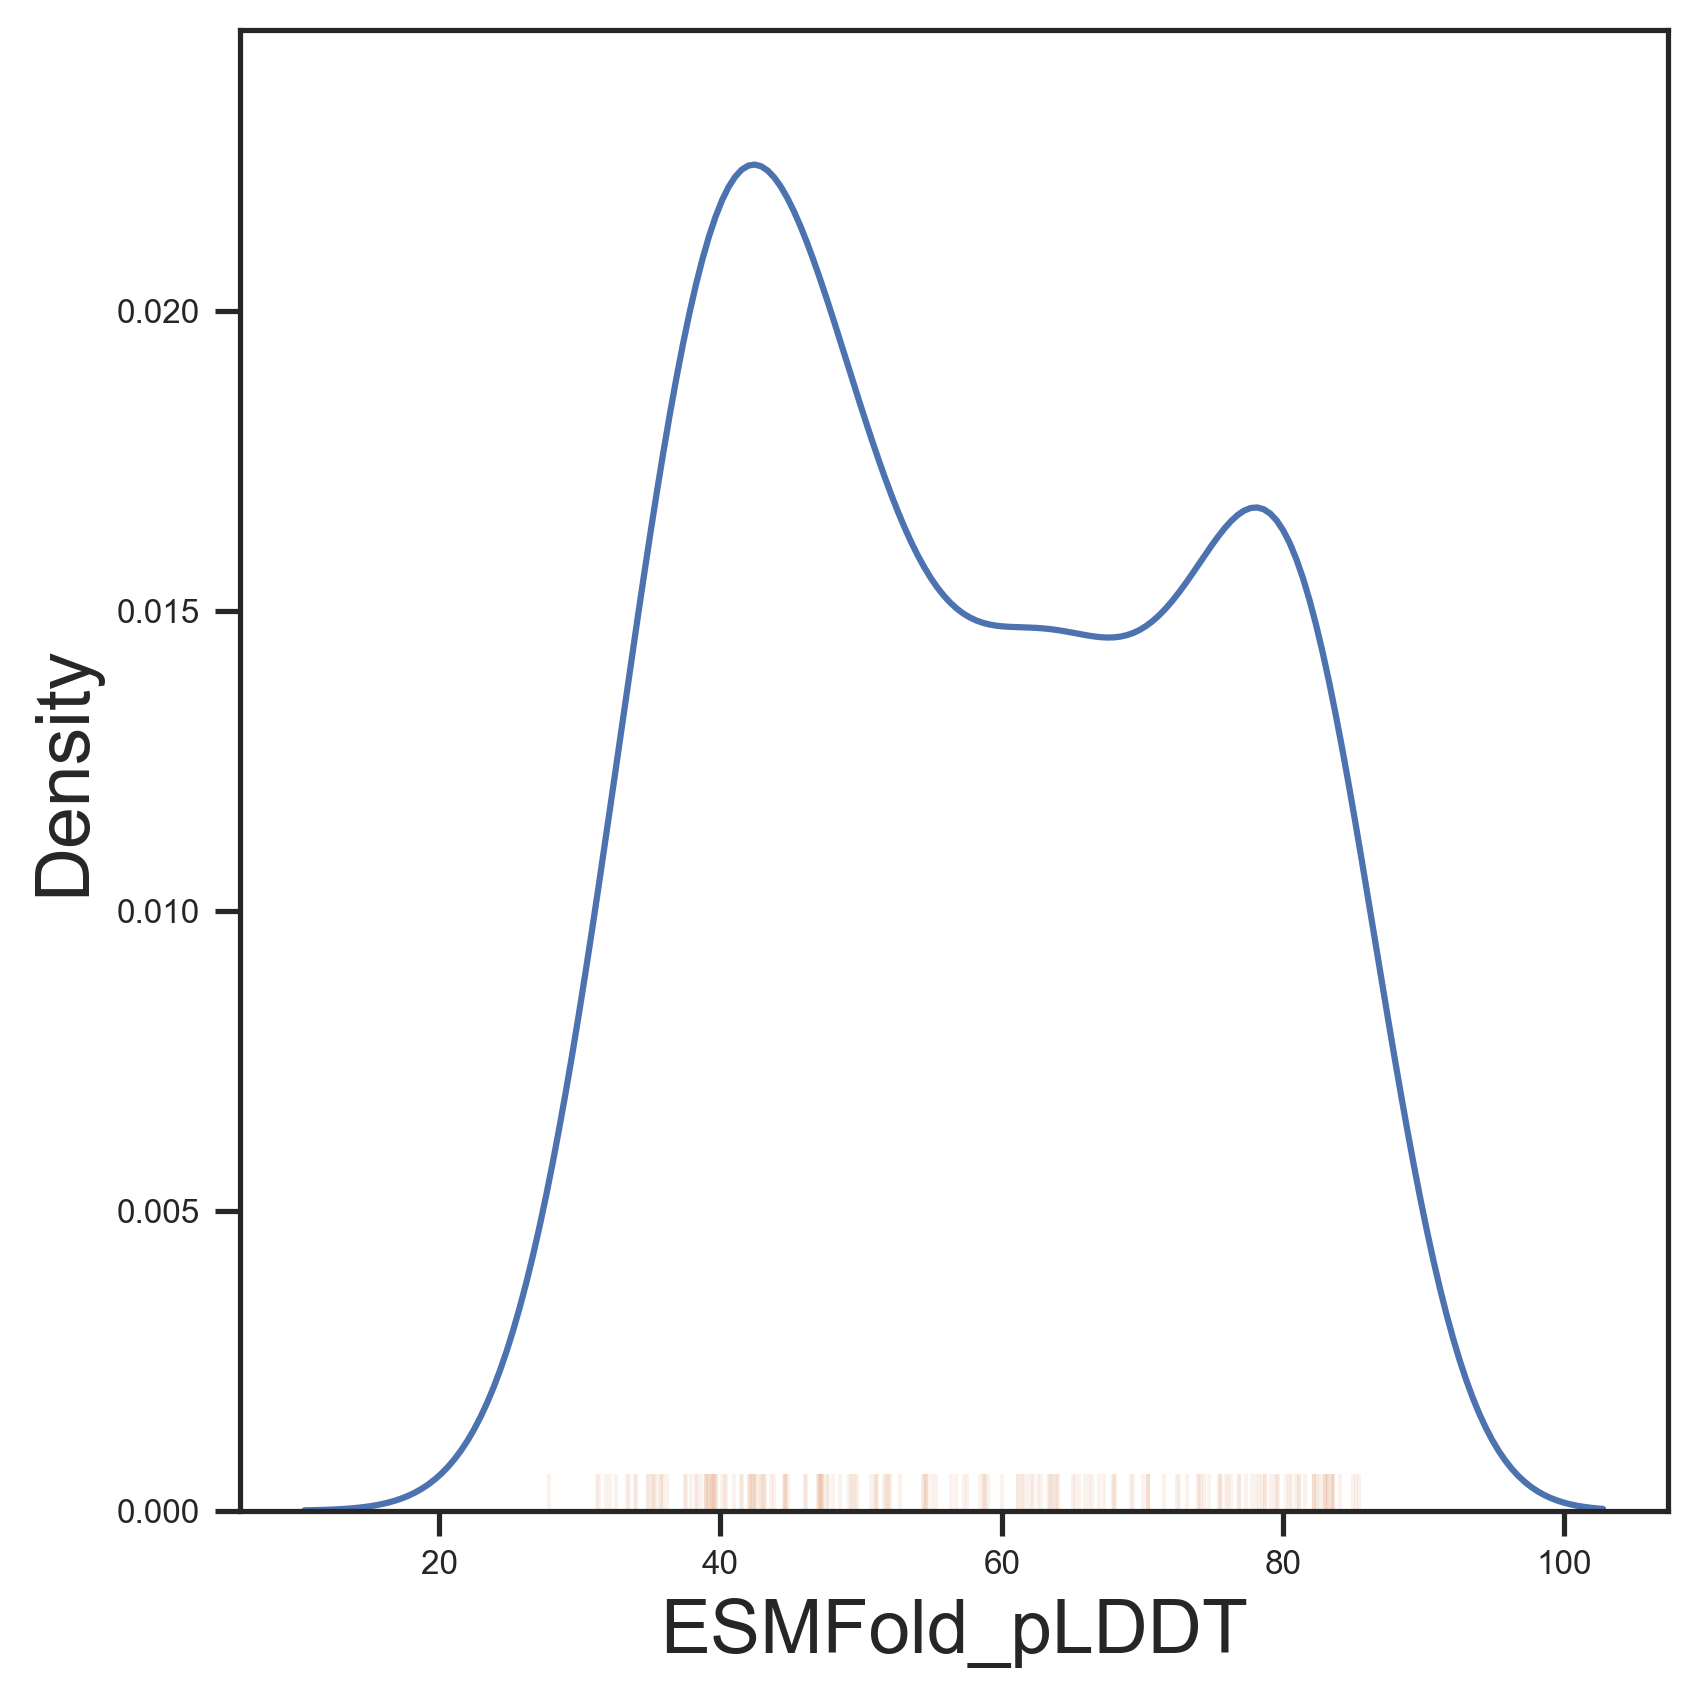

In [41]:
fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)

df=final_df.copy()

sns.kdeplot(data=df,x='ESMFold_pLDDT')
sns.rugplot(data=df,x='ESMFold_pLDDT',alpha=0.1)

#plt.legend(title=hu,loc=(1.1,0.1))
plt.legend('',frameon=False)

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.tight_layout()
#plt.savefig('output.svg',transparent=True,dpi=2000)


In [42]:
df_best

index pdb_file                                           sequence  \
130    132      _38  MEEELKKLKEEAEKALAIYKSTPVSTEPEGEEFLKKVEEIAKKVTK...   
132    134       _4  SEELKKFAKEAVEKALKLANAAPNNAKGQAAVKEAAKKAKEALEKA...   
134    136      _41  AAAIVDRCLADIDRARDLLLAEPLGEAGERGVAALERLRERARAAA...   
135    137      _42  SLAKLLAAAVIAAALAAYALRNPVNLDVLVRWFLAALAIALVVIAV...   
143    145       _5  MLLLCLALALYAVLYARRLLGVPLGEAERRAGLITFITTLLICLAI...   
150    152      _10  MEELLRRLTEESERCRELSLAEPLNKDVLEEAKELEEKVIEKAEEE...   
151    153      _11  SEREKIVEEAVELMREEANKDQEIGSSLEEAEKLTRECLEILAEVC...   
160    162       _2  MEAEQERLAEEAVRLAREFCKVPVNKEVEERYAAAVRAAARAIGEV...   
163    165      _22  MDALLAEASALAREAAAKALANPLNKDVVEKERALGDELAARIIAA...   
165    167      _24  LEALARECIELAVAEMRKVLKEPVNQDVLDEVEALVRRCCEALARH...   
170    172      _29  MMEDVERAAELLERAVDEATRTPSPEADKYAEKCREELEEMLRAAK...   
172    174      _30  MLEEAERAARELRELGEKMLKDPLLSEEEVAARRARVAAAADRAAA...   
175    177      _33  MEEILKKLEEFERYAEKLANSQPLNDYAKELRERLLALGREFAARL...   
179    181      _37  LTEELLELAKECLALGRKMLAEPLGELTEEALKKLEEAEKLLEETK...   
180    182      _38  MEEHLERLKELAEKAKELFYSTPLNTDETVEKLVATAEEVAAAATR...   
181    183      _39  TEATRREVAALLARAIEIALGNPLGEELTKRAEEAAAEARAAVARL...   
182    184       _4  SDELRRFGREAVERALELALATPLDPEGQARVEEEARRALALLEAA...   
185    187      _42  MDELLRRAAEEARALAAEALKEPVNKDVLERNFAAAERIADAVIRE...   
194    196       _6  MREECEREAEELTKKAEKKAKVPVNKNAIERTLKLAFALMEVVARA...   
195    197       _7  MEEVCELAIELAKECYEKAMSVPLNKDIEEKLKKEVEEYLKELEEA...   

      score global_score seq_recovery  \
130  0.9770       1.2266       0.0455   
132  0.9473       1.2145       0.0606   
134  0.9870       1.2318       0.0657   
135  0.9423       1.2148       0.0404   
143  1.0365       1.2590       0.0455   
150  0.9462       1.2189       0.0404   
151  0.9597       1.2261       0.0455   
160  0.9735       1.2225       0.0303   
163  0.9922       1.2345       0.0404   
165  0.9547       1.2193       0.0556   
170  0.9771       1.2340       0.0505   
172  0.9402       1.2122       0.0455   
175  0.8967       1.1843       0.0505   
179  1.0280       1.2538       0.0606   
180  0.9673       1.2276       0.0455   
181  0.9281       1.1968       0.0707   
182  1.0093       1.2458       0.0657   
185  0.9400       1.2153       0.0455   
194  0.9081       1.1818       0.0657   
195  1.0332       1.2598       0.0505   

                                       fasta_file_path PMPNN weights  \
130  RF_diff/round2/normal_weights/PMPNN/normal_wei...        normal   
132  RF_diff/round2/normal_weights/PMPNN/normal_wei...        normal   
134  RF_diff/round2/normal_weights/PMPNN/normal_wei...        normal   
135  RF_diff/round2/normal_weights/PMPNN/normal_wei...        normal   
143  RF_diff/round2/normal_weights/PMPNN/normal_wei...        normal   
150  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
151  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
160  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
163  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
165  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
170  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
172  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
175  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
179  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
180  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
181  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
182  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
185  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
194  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   
195  RF_diff/round2/normal_weights/PMPNN/soluble_we...       soluble   

     sequence_length                    RDiff_pdb_file_path  ...  \
130    

In [43]:
df_best['RF_weights'].value_counts()

RF_weights
Normal    20
Name: count, dtype: int64

In [44]:
df_best['PMPNN weights'].value_counts()

PMPNN weights
soluble    15
normal      5
Name: count, dtype: int64

In [45]:
df_best=df_best.sort_values('ESMFold_pLDDT',ascending=False)

In [46]:
df_best = df_best.reset_index(drop=True)
df_best = df_best.reset_index(drop=False)

In [47]:
df_best

level_0  index pdb_file  \
0         0    197       _7   
1         1    172      _29   
2         2    153      _11   
3         3    187      _42   
4         4    167      _24   
5         5    182      _38   
6         6    132      _38   
7         7    165      _22   
8         8    181      _37   
9         9    137      _42   
10       10    177      _33   
11       11    174      _30   
12       12    183      _39   
13       13    136      _41   
14       14    134       _4   
15       15    196       _6   
16       16    162       _2   
17       17    184       _4   
18       18    152      _10   
19       19    145       _5   

                                             sequence   score global_score  \
0   MEEVCELAIELAKECYEKAMSVPLNKDIEEKLKKEVEEYLKELEEA...  1.0332       1.2598   
1   MMEDVERAAELLERAVDEATRTPSPEADKYAEKCREELEEMLRAAK...  0.9771       1.2340   
2   SEREKIVEEAVELMREEANKDQEIGSSLEEAEKLTRECLEILAEVC...  0.9597       1.2261   
3   MDELLRRAAEEARALAAEALKEPVNKDVLERNFAAAERIADAVIRE...  0.9400       1.2153   
4   LEALARECIELAVAEMRKVLKEPVNQDVLDEVEALVRRCCEALARH...  0.9547       1.2193   
5   MEEHLERLKELAEKAKELFYSTPLNTDETVEKLVATAEEVAAAATR...  0.9673       1.2276   
6   MEEELKKLKEEAEKALAIYKSTPVSTEPEGEEFLKKVEEIAKKVTK...  0.9770       1.2266   
7   MDALLAEASALAREAAAKALANPLNKDVVEKERALGDELAARIIAA...  0.9922       1.2345   
8   LTEELLELAKECLALGRKMLAEPLGELTEEALKKLEEAEKLLEETK...  1.0280       1.2538   
9   SLAKLLAAAVIAAALAAYALRNPVNLDVLVRWFLAALAIALVVIAV...  0.9423       1.2148   
10  MEEILKKLEEFERYAEKLANSQPLNDYAKELRERLLALGREFAARL...  0.8967       1.1843   
11  MLEEAERAARELRELGEKMLKDPLLSEEEVAARRARVAAAADRAAA...  0.9402       1.2122   
12  TEATRREVAALLARAIEIALGNPLGEELTKRAEEAAAEARAAVARL...  0.9281       1.1968   
13  AAAIVDRCLADIDRARDLLLAEPLGEAGERGVAALERLRERARAAA...  0.9870       1.2318   
14  SEELKKFAKEAVEKALKLANAAPNNAKGQAAVKEAAKKAKEALEKA...  0.9473       1.2145   
15  MREECEREAEELTKKAEKKAKVPVNKNAIERTLKLAFALMEVVARA...  0.9081       1.1818   
16  MEAEQERLAEEAVRLAREFCKVPVNKEVEERYAAAVRAAARAIGEV...  0.9735       1.2225   
17  SDELRRFGREAVERALELALATPLDPEGQARVEEEARRALALLEAA...  1.0093       1.2458   
18  MEELLRRLTEESERCRELSLAEPLNKDVLEEAKELEEKVIEKAEEE...  0.9462       1.2189   
19  MLLLCLALALYAVLYARRLLGVPLGEAERRAGLITFITTLLICLAI...  1.0365       1.2590   

   seq_recovery                                    fasta_file_path  \
0        0.0505  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
1        0.0505  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
2        0.0455  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
3        0.0455  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
4        0.0556  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
5        0.0455  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
6        0.0455  RF_diff/round2/normal_weights/PMPNN/normal_wei...   
7        0.0404  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
8        0.0606  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
9        0.0404  RF_diff/round2/normal_weights/PMPNN/normal_wei...   
10       0.0505  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
11       0.0455  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
12       0.0707  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
13       0.0657  RF_diff/round2/normal_weights/PMPNN/normal_wei...   
14       0.0606  RF_diff/round2/normal_weights/PMPNN/normal_wei...   
15       0.0657  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
16       0.0303  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
17       0.0657  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
18       0.0404  RF_diff/round2/normal_weights/PMPNN/soluble_we...   
19       0.0455  RF_diff/round2/normal_weights/PMPNN/normal_wei...   

   PMPNN weights  sequence_length  ... instability_index  flexibility  \
0        soluble              198  ...         47.593750     1.014648   
1        soluble              198  ...         53.000000     1.008789   
2        soluble       

In [48]:
df_best['attempt']=2
df_best.to_excel('att2.xlsx')

In [ ]:
SngA_seq = 'MEFWIFIIAIYLIYIIFFKKKKPKSAGSYTSAPVKAPPKEWLANNKKNQAVMHNDDSEDDNLATFTLSGGRNVEYSITATQRQNPSKTTGALARWILPGEVLTVGGVEVTGGHFYLGQRMKPAGHNSGGYYDDSSEASLIDDTLKIYPTPYIYEDSSLGYWPSFSSLSPEARGAYLSWLASDRCDTSCPIGYVFIYLYGLERRALVDSRNNSISDNEFYSLFKEICRLRSVFNENRSFRNYSSQLLEAMSILRPNENLAAALGNDSEFSNGMQFRLILAKTVEAGAPVPADLALTWVTNHTEYSLRTPARRCAKEFAALFKRRYTFKYDEGMVVKPNKARLRLDYTPASPSLRGIRLPVPDLPDPSALKGPVQKLMTLADICTDELDAYSRYLGRKGTSANDTAAILLLPSEIVNESAEKILSAFKRWADDAILSKAGVVSVADYWSHMNATCPAKINKKEADLMQAFAQKMGYCLAPDPYYHHVKADVDGVLVLFPAGEGGRFSPSPEFITAVLTLRLGAVVALIDNSLDQAEQKVLENAINNNAGFSDDEKRSLHAYLTWQLHTPANMTGMKSRIELLGAAEKSAVGKVIVSVACSDGRITPVEVKQLEKIYTSLGLDPSSVSSNIHQHSTTETALVSSVPANQSTAGFTLDANVLARHESATDDVRKLLNSIFTEEEPEQPESAPASLTGEGGLDPAHSQLYRRLLDKEQWSRKEATELCSNWNLMLGGALEVINDWSYAVVDAPVLEDTDDHIWVDLEIAKELEG'



In [ ]:
SngA_seq[500:]

In [ ]:
def write_fasta_files_AFpulldown(df):
    
    # Iterate over rows of the dataframe
    for index, row in df.iterrows():
        # Generate the filename for the FASTA file using the pdb_file column
        file_name = f"AF_pulldown.fasta"
        file_name_txt = f"AF_pulldown.txt"
        
        # Write the sequence to the FASTA file
        with open(file_name, "a") as fasta_file:
            fasta_file.write(f">{index}\n")
            fasta_file.write(f"{row['sequence']}\n")
            
        # Write the sequence to the FASTA file
        with open(file_name_txt, "a") as fasta_file:
            fasta_file.write(f"{index}\n")
            
write_fasta_files_AFpulldown(df_best)


# Go run AF pulldown

In [60]:
df_AFpulldown_results = pd.read_csv('./AlphaPulldown/predictions_with_good_interpae.csv')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 6000x6000 with 0 Axes>

<Figure size 6000x6000 with 0 Axes>

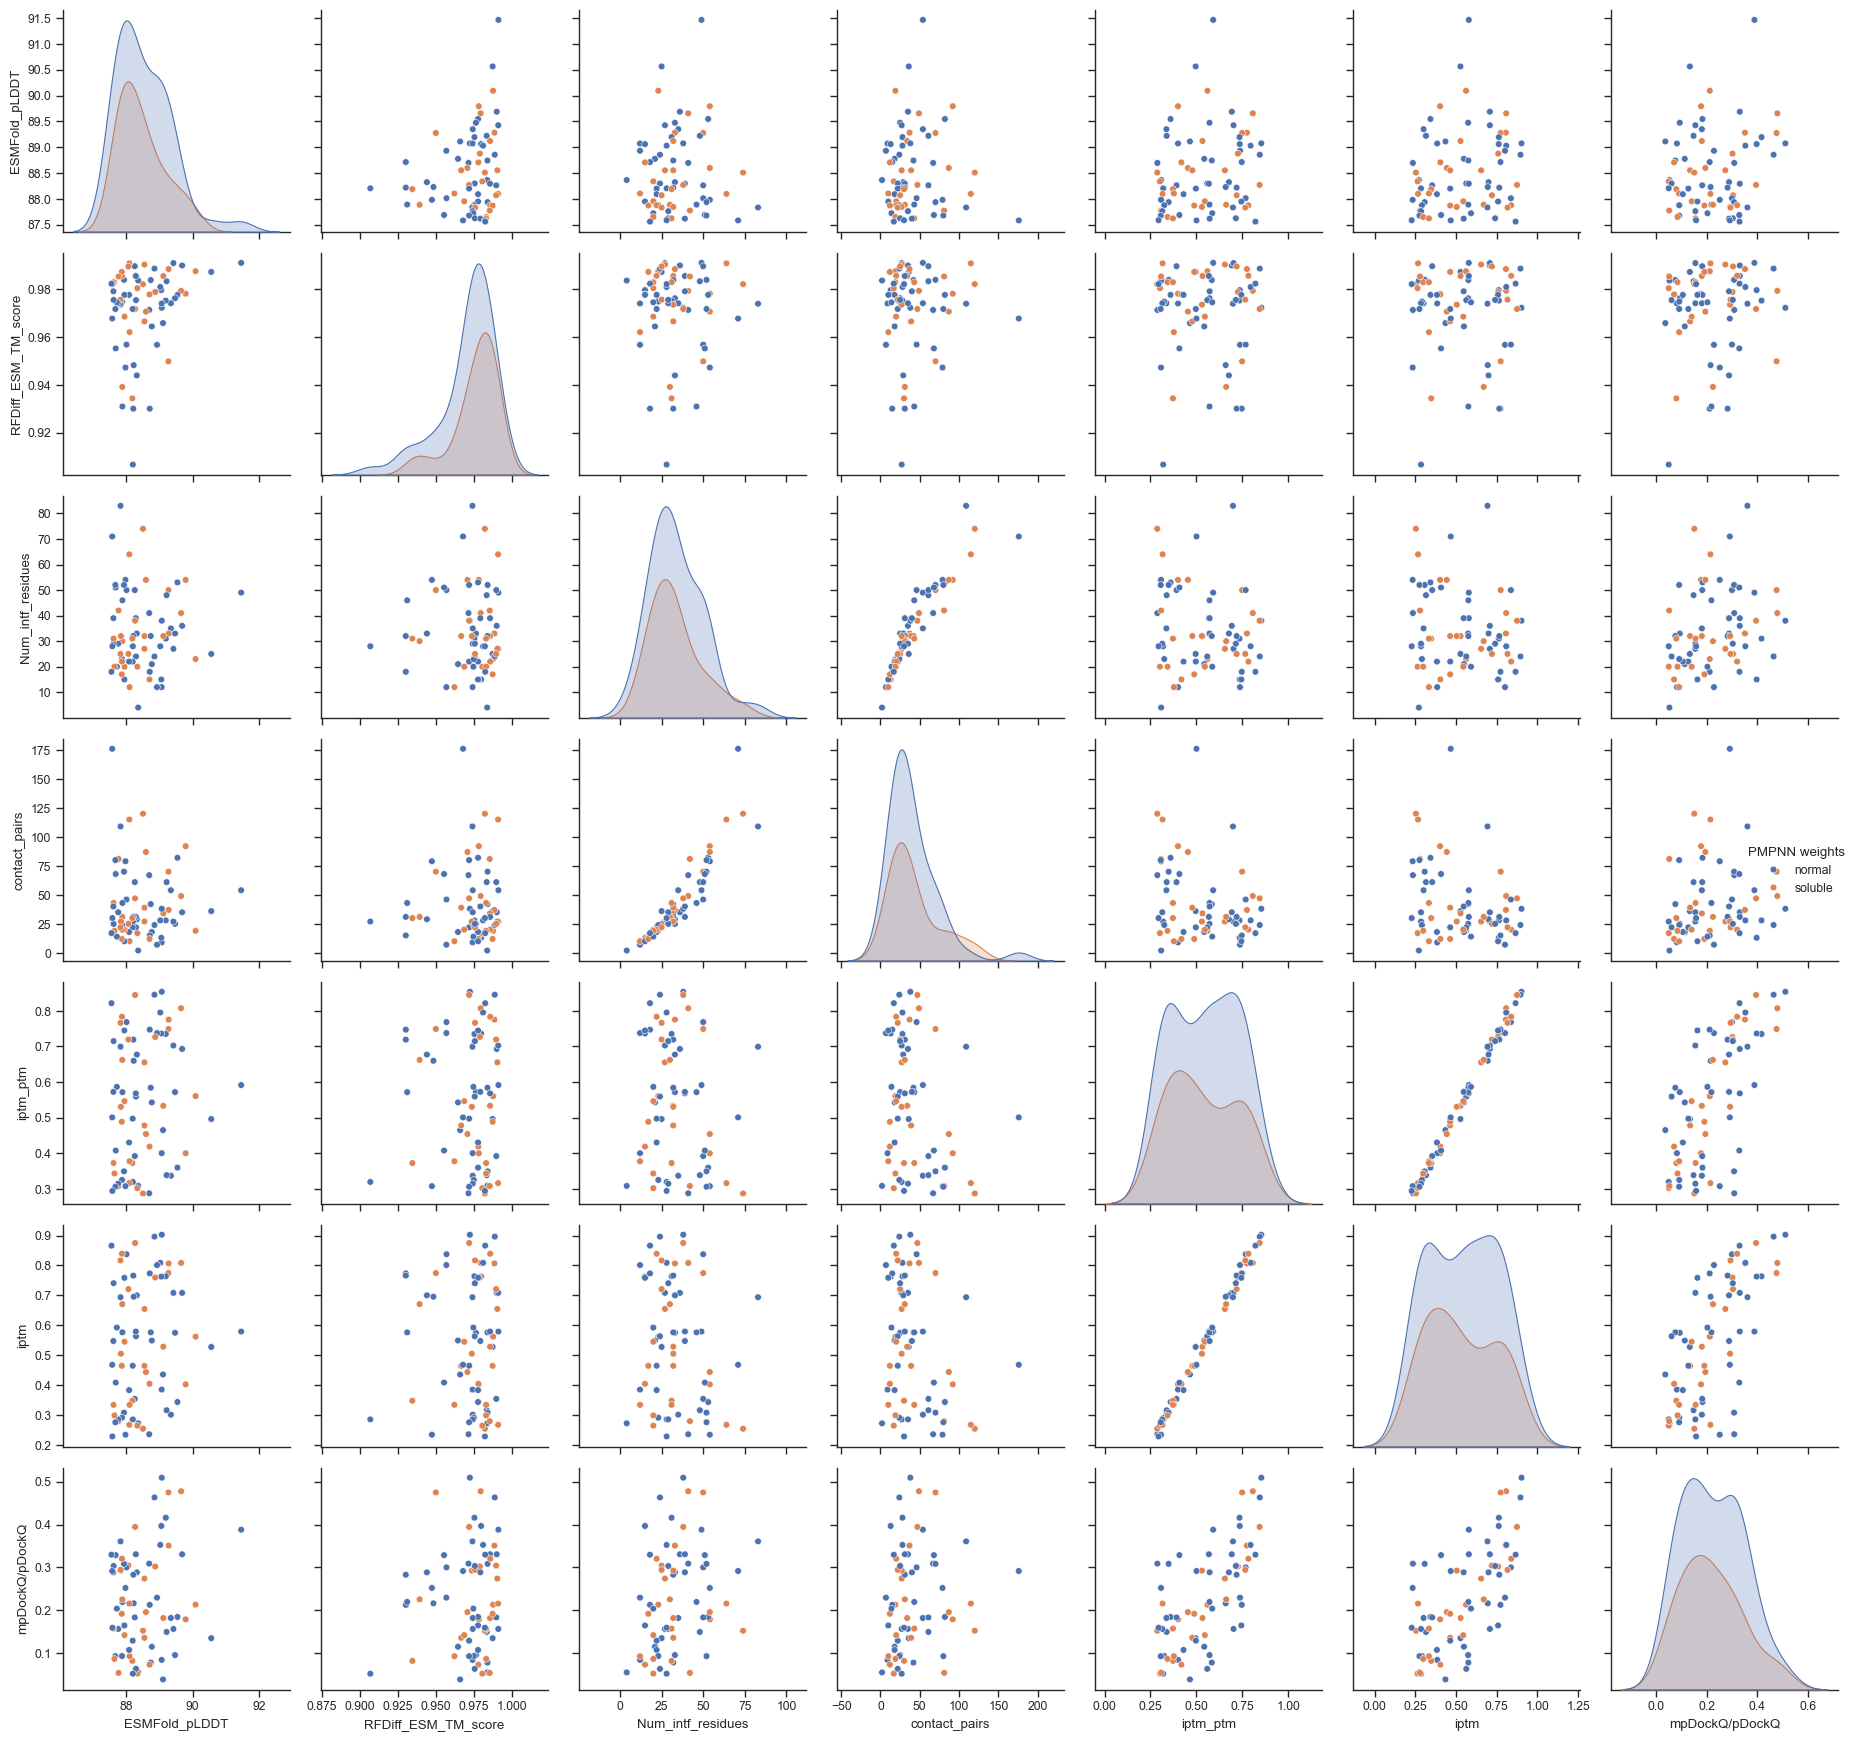

In [ ]:

df_AFpulldown_results['jobs_index'] = df_AFpulldown_results['jobs'].str.extract('(\d+)').astype(int)
df_AFpulldown_results=df_AFpulldown_results.sort_values('jobs_index')
df_AFpulldown_results=df_AFpulldown_results.set_index('jobs_index')
df_results=df_best.merge(df_AFpulldown_results,left_index=True,right_index=True)
df_results=df_results[['index', 'jobs',
      'ESMFold_pLDDT', 'RFDiff_ESM_TM_score', 
       'Num_intf_residues', 'Polar', 'Hydrophobhic', 'Charged',
       'contact_pairs', ' sc', ' hb', ' sb', ' int_solv_en', ' int_area',
       'pi_score', 'iptm_ptm', 'iptm', 'mpDockQ/pDockQ',
                    
        'pdb_file', 'sequence', 'sequence_length',

       'RDiff_pdb_file_path', 'molecular_weight', 'aromaticity',
       'instability_index', 'flexibility', 'isoelectric_point',
      
        'PMPNN weights', 'score', 'global_score',   'seq_recovery',
         'RF_weights', 
        'fasta_path', 'fasta_file_path','ESM_pdb_path', 'RFDiff_binder_pdb_path',]]
plot_df = df_results[[
      'ESMFold_pLDDT', 'RFDiff_ESM_TM_score', 
       'Num_intf_residues', 
       'contact_pairs',
       'pi_score', 'iptm_ptm', 'iptm', 'mpDockQ/pDockQ',
        'PMPNN weights', 
       ]]
plt.clf()
sns.set_context('paper')
sns.set_style('ticks')
fig = plt.figure(0,(10,10),dpi=600) 
sns.pairplot(plot_df, hue="PMPNN weights",)

#plt.xticks(size=25)
#plt.yticks(size=25)

plt.tight_layout()
plt.savefig('all_v_all_AFpulldown_PMPNN_weights.png',transparent=True)
plt.show()

In [ ]:
df_results.columns

In [ ]:
df=df_results.copy()

cut_TM = 0.5 #0.26
cut_pLDDT = 0.23

TM_col_name = 'iptm'
pLDDT_col_name = 'mpDockQ/pDockQ'
df_TM = df[df[TM_col_name]>cut_TM]
df_pLDDT = df_TM[df_TM[pLDDT_col_name]>cut_pLDDT]
df_best = df_pLDDT[df_pLDDT[TM_col_name]>cut_TM]

fnt= 8
plt.clf()
sns.set_context('paper')
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.figure(0,(6,6),dpi=300)
hu=pLDDT_col_name

plt.axhline(y=cut_pLDDT,zorder=-2)
plt.axvline(x=cut_TM,zorder=-2)

sns.scatterplot(data=df,x=TM_col_name,y=pLDDT_col_name,hue=hu,palette='RdYlBu',edgecolor='k',zorder=1)
#sns.scatterplot(data=df_best,x=TM_col_name,y=pLDDT_col_name

sns.kdeplot(data=df,x=TM_col_name,y=pLDDT_col_name,color='grey',bw_adjust=0.65,levels=5,alpha=0.2,zorder=-1)
#sns.scatterplot(data=df,x='TM-scores',y='pLDDT',sizes='Length')
#sns.lmplot(data=df,x='TM-scores',y='pLDDT',ci='sd')
plt.legend('',frameon=False)
#plt.legend(title=hu,loc=(1.1,0.1))

plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)
#plt.ylabel('2BC/(BB+CC) (REU)',fontsize=12)
#plt.xlabel('Generation',fontsize=12)
plt.tight_layout()
print('################\n###Saving data and plot###\n################')
#plt.savefig('output.svg',transparent=True,dpi=2000)


In [ ]:
df_results.columns

In [ ]:
!pwd

In [ ]:
df_to_order=df_results.copy()


In [ ]:
df_to_order= df_to_order[df_to_order['mpDockQ/pDockQ']>0.23]
df_to_order= df_to_order[df_to_order['iptm']>0.5]

In [ ]:
df_to_order['sequence']

In [ ]:
def add_Met(sequence):
    if sequence.startswith('M'):
        return sequence
    else:
        return 'M' + sequence

# Apply the function to the 'sequence' column
df_to_order['sequence'] = df_to_order['sequence'].apply(add_Met)

In [ ]:
df_to_order.to_excel('df_to_order.xlsx')

In [ ]:
df_to_genscript = df_to_order[['index','sequence', 'sequence_length', 
       'molecular_weight', 'aromaticity', 'instability_index', 'flexibility',
       'isoelectric_point']]

In [ ]:
df_to_genscript.rename(columns={"index": "Design Number / Name"})
df_to_genscript.to_excel('genscript_sheet.xlsx')